# DEMO

In [7]:
from qutip import *
import numpy as np 
import matplotlib.pyplot as plt
import math
from skimage.feature import peak_local_max
import pickle
import os
import glob
import heapq

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'

##  plot peaks

In [5]:
def routine(E_i,wd_i):
    
    print('running param set {} {}'.format(E_i, wd_i))
    
    # Define all the variables 
    kappa = 0.0012 # 0.0012 
    gJC = 0.3347 # 0.3347
    wc = 10.5665 # Cavity frequency/detuning 10.5665
    w0 = 8.1831 # Qubit frequency 8.1831
    gamma=0.0001 # 0.0001
    Emax =0.01 # 0.01
    EN=1
    #E = 0.01 #0.01(original) # Epsilon
    E = E_i
    N = 50 #50
    nloop = 1

    #wd = 10.6005 # Driving frequency (10.6005 original)
    wd = wd_i
    wlist = np.linspace(wd, wd,nloop)

    # Identity operators are defined for the space of the light field and the space of the atom

    ida = identity(N)
    idatom = identity(2)

    # Define cavity field and atomic operators

    a  = tensor(destroy(N),idatom)
    sm = tensor(ida,sigmam())

    # Hamiltonian # Reminder check hamiltonian from caltech paper

    H1= 1*gJC*(a.dag()*sm + sm.dag()*a) + 1*E*(a+a.dag())

    # Collapse Operators

    C1    = math.sqrt(kappa)*a
    C2    = math.sqrt(gamma)*sm

    C1dC1 = C1.dag()*C1
    C2dC2 = C2.dag()*C2

    # Calculate the Liouvillian

    L1 = spre(C1)*spost(C1.dag())-0.5*spre(C1dC1)-0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag())-0.5*spre(C2dC2)-0.5*spost(C2dC2)
    L12  = L1+L2

    gQ=math.sqrt(4)
    xvec=  np.arange(-10,10.01,0.025) # 0.025
    yvec = np.arange(-10,10.01,0.025) 

    #print("epsilon", E)
    #print("and drive frequency", wd)
    #print("kappa", kappa)
    k=0
    while k < nloop :
        wl = wlist[k]    
        H = (w0-wl)*(sm.dag()*sm) + (wc-wl)*(a.dag()*a) + H1    
        LH = -complex(0,1) * (spre(H) - spost(H))
        L_final = LH + L12

        # Steady States

        rhoss = steadystate(L_final)
        rhosscav=ptrace(rhoss,0)
        rhocavsq=rhosscav*rhosscav
        k += 1

        #subplot(ceil(sqrt(nloop)), 
        #ceil(sqrt(nloop)), k)
    plt.rcParams['figure.figsize'] = (20.0, 16.0)
    fig, ax = plt.subplots()
    Q3 = qfunc(rhosscav,xvec,yvec,gQ)
    c = ax.contourf(xvec, yvec, np.real(Q3), 500, cmap=plt.cm.get_cmap('winter'))
    

#         ax.set_xlim([-3.5, 6]) # -3.5 to 6
#         ax.set_ylim([-4, 3])
    plt.colorbar(c, ax=ax)
    plt.xlabel('x')
    plt.ylabel('y')
    


        #contour(xvec,yvec,real(Q3), 500)
        #plt.plot(xvec,yvec)
        #plt.show()
        #print(rhosscav)
        #print(rhoss)
    
    coordinates = peak_local_max(Q3)    
    for coord in coordinates:
        print('peak coords:{}'.format(coord))        
        coordHeight = Q3[coord[0], coord[1]]
        print('peak height:{}'.format(coordHeight))
        plt.plot(xvec[coord[1]], yvec[coord[0]], 'o', label='{}: {}'.format(coord, coordHeight))        
    plt.legend()
    plt.show()
    #print (Q3[coordinates])
    
#     newKey = len(savedInfo.keys()) + 1
    
#     infoPacket = {}
#     infoPacket['E_i'] = E_i
#     infoPacket['wd_i'] = wd_i
#     infoPacket['coors'] = coordinates
#     infoPacket['peaks'] = Q3[coordinates]
#     infoPacket['Q3'] = Q3
#     infoPacket['xvec'] = xvec
#     infoPacket['yvec'] = yvec
#     return infoPacket

## read peaks

In [ ]:
relevantInfo = []
for peak in glob.glob(os.path.join('/mnt/c/Users/manish/Documents/GitHub/qpeak/peaks/peaksTipFiner', '*')):    
    savedInfo = pickle.load(open(peak, 'rb'))    
    
    coors = savedInfo['coors']    
#     peaks = []
#     for coor in coors:        
#         peaks.append(savedInfo['Q3'][coor[0], coor[1]])
    peaks = savedInfo['peaks']
        
    relevantInfo_i = {}
    relevantInfo_i['peakName'] = peak
    relevantInfo_i['E'] = savedInfo['E_i']
    relevantInfo_i['wd'] = savedInfo['wd_i']
    if savedInfo['wd_i'] <= 0:
        print(savedInfo['wd_i'])
        break
    
    relevantInfo_i['peaks'] = peaks
    relevantInfo_i['coors'] = coors
    relevantInfo.append(relevantInfo_i)
    print('E:{}, wd_i:{}, coords:{}, peaks:{}'.format(relevantInfo_i['E'], relevantInfo_i['wd'], relevantInfo_i['coors'],relevantInfo_i['peaks']))
    
print(len(relevantInfo))

E:0.00125, wd_i:10.61, coords:[[390 379]], peaks:[0.234704914936818]
E:0.00125, wd_i:10.610010101, coords:[[389 379]], peaks:[0.23311259014703428]
E:0.00125, wd_i:10.6101010101, coords:[[387 378]], peaks:[0.2184885166676533]
E:0.00125101010101, wd_i:10.61, coords:[[390 379]], peaks:[0.23432307117685167]
E:0.0012601010101, wd_i:10.61, coords:[[389 379]], peaks:[0.2309043384757771]
E:0.0012601010101, wd_i:10.610010101, coords:[[389 379]], peaks:[0.2292797144457378]
E:0.0012601010101, wd_i:10.610020202, coords:[[389 379]], peaks:[0.22763822418589252]
E:0.0012601010101, wd_i:10.610030303, coords:[[389 378]], peaks:[0.22599140041058097]
E:0.0012601010101, wd_i:10.610040404, coords:[[388 378]], peaks:[0.2243785932935009]
E:0.0012601010101, wd_i:10.6100505051, coords:[[388 378]], peaks:[0.22275067494067785]
E:0.0012601010101, wd_i:10.6100606061, coords:[[388 378]], peaks:[0.22110853307544723]
E:0.0012601010101, wd_i:10.6100707071, coords:[[388 378]], peaks:[0.21945312311805198]
E:0.0012601010

E:0.0012601010101, wd_i:10.6109090909, coords:[[356 414]], peaks:[0.1671314030317648]
E:0.0012601010101, wd_i:10.6109191919, coords:[[356 415]], peaks:[0.167948382304832]
E:0.0012601010101, wd_i:10.6109292929, coords:[[356 416]], peaks:[0.1687723489414772]
E:0.0012601010101, wd_i:10.6109393939, coords:[[356 416]], peaks:[0.16959964915344908]
E:0.0012601010101, wd_i:10.6109494949, coords:[[356 417]], peaks:[0.17043221616518575]
E:0.0012601010101, wd_i:10.610959596, coords:[[357 418]], peaks:[0.1712739063114846]
E:0.0012601010101, wd_i:10.610969697, coords:[[357 419]], peaks:[0.1721342389890276]
E:0.0012601010101, wd_i:10.610979798, coords:[[357 419]], peaks:[0.17298704947740348]
E:0.0012601010101, wd_i:10.610989899, coords:[[357 420]], peaks:[0.17383414777370373]
E:0.0012601010101, wd_i:10.611, coords:[[357 420]], peaks:[0.17467949281780065]
E:0.00125, wd_i:10.6101111111, coords:[[387 378]], peaks:[0.21686747508378276]
E:0.00125101010101, wd_i:10.6101010101, coords:[[387 378]], peaks:[0

E:0.00126111111111, wd_i:10.6108989899, coords:[[356 413]], peaks:[0.16636625796903884]
E:0.00125101010101, wd_i:10.6101919192, coords:[[385 378]], peaks:[0.2036883932332685]
E:0.00126111111111, wd_i:10.6109090909, coords:[[356 414]], peaks:[0.1671770113992455]
E:0.00126111111111, wd_i:10.6109191919, coords:[[356 415]], peaks:[0.16799994929385698]
E:0.00126111111111, wd_i:10.6109292929, coords:[[356 416]], peaks:[0.16882973745089702]
E:0.00126111111111, wd_i:10.6109393939, coords:[[356 417]], peaks:[0.1696605214676656]
E:0.00126111111111, wd_i:10.6109494949, coords:[[356 417]], peaks:[0.17049310476869153]
E:0.00126111111111, wd_i:10.610959596, coords:[[357 419]], peaks:[0.17134468689646945]
E:0.00126111111111, wd_i:10.610969697, coords:[[357 419]], peaks:[0.17220491290218112]
E:0.00126111111111, wd_i:10.610979798, coords:[[357 419]], peaks:[0.17305561364544864]
E:0.00126111111111, wd_i:10.610989899, coords:[[357 420]], peaks:[0.17390811133664782]
E:0.00126111111111, wd_i:10.611, coords

E:0.00126212121212, wd_i:10.6107979798, coords:[[357 401]], peaks:[0.15976218922034943]
E:0.00125101010101, wd_i:10.6102828283, coords:[[382 378]], peaks:[0.19046477902649964]
E:0.00126212121212, wd_i:10.6108080808, coords:[[357 402]], peaks:[0.16025078481373917]
E:0.00126212121212, wd_i:10.6108181818, coords:[[356 404]], peaks:[0.16077994483492083]
E:0.00126212121212, wd_i:10.6108282828, coords:[[356 405]], peaks:[0.1613738834633796]
E:0.00126212121212, wd_i:10.6108383838, coords:[[356 406]], peaks:[0.161999392661042]
E:0.00126212121212, wd_i:10.6108484848, coords:[[356 407]], peaks:[0.16265662392188804]
E:0.00126212121212, wd_i:10.6108585859, coords:[[356 409]], peaks:[0.1633454820359399]
E:0.00126212121212, wd_i:10.6108686869, coords:[[356 410]], peaks:[0.16407213210821764]
E:0.00126212121212, wd_i:10.6108787879, coords:[[356 411]], peaks:[0.16482641094605294]
E:0.00126212121212, wd_i:10.6108888889, coords:[[356 413]], peaks:[0.16560726117752914]
E:0.00126212121212, wd_i:10.61089898

E:0.00126313131313, wd_i:10.6106464646, coords:[[365 387]], peaks:[0.1575743333429409]
E:0.00126313131313, wd_i:10.6106565657, coords:[[364 388]], peaks:[0.1574238469057263]
E:0.00126313131313, wd_i:10.6106666667, coords:[[364 388]], peaks:[0.15729833827060974]
E:0.00126313131313, wd_i:10.6106767677, coords:[[363 389]], peaks:[0.15723650635339048]
E:0.00126313131313, wd_i:10.6106868687, coords:[[362 390]], peaks:[0.1571957775165539]
E:0.00126313131313, wd_i:10.6106969697, coords:[[362 390]], peaks:[0.1571984058186259]
E:0.00125101010101, wd_i:10.6103737374, coords:[[378 379]], peaks:[0.1791381767929741]
E:0.00126313131313, wd_i:10.6107070707, coords:[[361 391]], peaks:[0.15724065208083]
E:0.00126313131313, wd_i:10.6107171717, coords:[[361 392]], peaks:[0.1573434073299108]
E:0.00126313131313, wd_i:10.6107272727, coords:[[360 393]], peaks:[0.15747854757290194]
E:0.00126313131313, wd_i:10.6107373737, coords:[[360 394]], peaks:[0.15765607226921521]
E:0.00126313131313, wd_i:10.6107474747, c

E:0.00126414141414, wd_i:10.6105656566, coords:[[369 383]], peaks:[0.1599398260519864]
E:0.00126414141414, wd_i:10.6105757576, coords:[[368 384]], peaks:[0.15949058854738052]
E:0.00126414141414, wd_i:10.6105858586, coords:[[368 384]], peaks:[0.15908347488712204]
E:0.00126414141414, wd_i:10.6105959596, coords:[[367 385]], peaks:[0.15869954054286056]
E:0.00125101010101, wd_i:10.6104646465, coords:[[375 380]], peaks:[0.17021209210426974]
E:0.00126414141414, wd_i:10.6106060606, coords:[[367 385]], peaks:[0.15836625887298972]
E:0.00126414141414, wd_i:10.6106161616, coords:[[366 385]], peaks:[0.15806390211968477]
E:0.00126414141414, wd_i:10.6106262626, coords:[[365 386]], peaks:[0.1578014027872512]
E:0.00126414141414, wd_i:10.6106363636, coords:[[365 387]], peaks:[0.15757218339351167]
E:0.00126414141414, wd_i:10.6106464646, coords:[[364 387]], peaks:[0.15738498885485355]
E:0.00126414141414, wd_i:10.6106565657, coords:[[364 388]], peaks:[0.15724303677304838]
E:0.00126414141414, wd_i:10.610666

E:0.00126515151515, wd_i:10.6104646465, coords:[[374 380]], peaks:[0.1659293231305043]
E:0.00126515151515, wd_i:10.6104747475, coords:[[373 380]], peaks:[0.165157501241381]
E:0.00126515151515, wd_i:10.6104848485, coords:[[372 381]], peaks:[0.1644118538352609]
E:0.00126515151515, wd_i:10.6104949495, coords:[[372 381]], peaks:[0.16372428222941954]
E:0.00125101010101, wd_i:10.6105555556, coords:[[371 382]], peaks:[0.16375519016168544]
E:0.00126515151515, wd_i:10.6105050505, coords:[[372 381]], peaks:[0.16303903129858024]
E:0.00126515151515, wd_i:10.6105151515, coords:[[371 382]], peaks:[0.16238564425950014]
E:0.00126515151515, wd_i:10.6105252525, coords:[[370 382]], peaks:[0.16178313077237802]
E:0.00126515151515, wd_i:10.6105353535, coords:[[370 382]], peaks:[0.1612227945475326]
E:0.00126515151515, wd_i:10.6105454545, coords:[[370 382]], peaks:[0.16066296129950774]
E:0.00126515151515, wd_i:10.6105555556, coords:[[369 383]], peaks:[0.16017484058687773]
E:0.00126515151515, wd_i:10.610565656

E:0.00126616161616, wd_i:10.6103131313, coords:[[380 378]], peaks:[0.1809665429611094]
E:0.00126616161616, wd_i:10.6103232323, coords:[[379 378]], peaks:[0.17972011752264141]
E:0.00126616161616, wd_i:10.6103333333, coords:[[379 378]], peaks:[0.178523260781859]
E:0.00126616161616, wd_i:10.6103434343, coords:[[379 378]], peaks:[0.17733298227547906]
E:0.00126616161616, wd_i:10.6103535354, coords:[[378 378]], peaks:[0.17618319223445195]
E:0.00126616161616, wd_i:10.6103636364, coords:[[378 378]], peaks:[0.1750587051676547]
E:0.00126616161616, wd_i:10.6103737374, coords:[[377 379]], peaks:[0.1739770919239839]
E:0.00126616161616, wd_i:10.6103838384, coords:[[377 379]], peaks:[0.1729384776001016]
E:0.00126616161616, wd_i:10.6103939394, coords:[[377 379]], peaks:[0.17190625998850761]
E:0.00125101010101, wd_i:10.6106464646, coords:[[366 386]], peaks:[0.15997450847387296]
E:0.00126616161616, wd_i:10.6104040404, coords:[[376 379]], peaks:[0.170929437691324]
E:0.00126616161616, wd_i:10.6104141414, 

E:0.00126717171717, wd_i:10.6103030303, coords:[[380 378]], peaks:[0.18186605606026549]
E:0.00126717171717, wd_i:10.6103131313, coords:[[380 378]], peaks:[0.18060223150137966]
E:0.00126717171717, wd_i:10.6103232323, coords:[[379 378]], peaks:[0.17936482606985044]
E:0.00126717171717, wd_i:10.6103333333, coords:[[379 378]], peaks:[0.1781679183392486]
E:0.00126717171717, wd_i:10.6103434343, coords:[[379 378]], peaks:[0.17697769088561185]
E:0.00126717171717, wd_i:10.6103535354, coords:[[378 378]], peaks:[0.1758370652551816]
E:0.00126717171717, wd_i:10.6103636364, coords:[[378 378]], peaks:[0.17471267501402404]
E:0.00126717171717, wd_i:10.6103737374, coords:[[377 379]], peaks:[0.17364088943561196]
E:0.00126717171717, wd_i:10.6103838384, coords:[[377 379]], peaks:[0.17260244712514913]
E:0.00126717171717, wd_i:10.6103939394, coords:[[376 379]], peaks:[0.17157801476403886]
E:0.00125101010101, wd_i:10.6107474747, coords:[[361 392]], peaks:[0.15927045469964343]
E:0.00126717171717, wd_i:10.610404

E:0.00126818181818, wd_i:10.6103939394, coords:[[376 379]], peaks:[0.1712515561838541]
E:0.00125101010101, wd_i:10.6108484848, coords:[[357 403]], peaks:[0.16281801421330713]
E:0.00126818181818, wd_i:10.6104040404, coords:[[376 379]], peaks:[0.17027689112234712]
E:0.00126818181818, wd_i:10.6104141414, coords:[[376 379]], peaks:[0.1693080703471611]
E:0.00126818181818, wd_i:10.6104242424, coords:[[375 379]], peaks:[0.16838877820785705]
E:0.00126818181818, wd_i:10.6104343434, coords:[[374 380]], peaks:[0.16748807734623353]
E:0.00126818181818, wd_i:10.6104444444, coords:[[374 380]], peaks:[0.1666596715605025]
E:0.00126818181818, wd_i:10.6104545455, coords:[[374 380]], peaks:[0.1658355784540844]
E:0.00126818181818, wd_i:10.6104646465, coords:[[373 380]], peaks:[0.16504190438706934]
E:0.00126818181818, wd_i:10.6104747475, coords:[[373 380]], peaks:[0.16427236698074527]
E:0.00126818181818, wd_i:10.6104848485, coords:[[372 381]], peaks:[0.163562841139932]
E:0.00126818181818, wd_i:10.6104949495

E:0.00126919191919, wd_i:10.6103737374, coords:[[377 379]], peaks:[0.17296848557428904]
E:0.00126919191919, wd_i:10.6103838384, coords:[[377 379]], peaks:[0.17193045149908487]
E:0.00126919191919, wd_i:10.6103939394, coords:[[376 379]], peaks:[0.17092510982023112]
E:0.00125101010101, wd_i:10.6109494949, coords:[[356 414]], peaks:[0.16994743232716458]
E:0.00126919191919, wd_i:10.6104040404, coords:[[376 379]], peaks:[0.16995066358189811]
E:0.00126919191919, wd_i:10.6104141414, coords:[[375 379]], peaks:[0.1689859592916608]
E:0.00126919191919, wd_i:10.6104242424, coords:[[375 379]], peaks:[0.16807231788065544]
E:0.00126919191919, wd_i:10.6104343434, coords:[[374 380]], peaks:[0.16718289176945395]
E:0.00126919191919, wd_i:10.6104444444, coords:[[374 380]], peaks:[0.16635470103025968]
E:0.00126919191919, wd_i:10.6104545455, coords:[[374 380]], peaks:[0.16553088553239206]
E:0.00126919191919, wd_i:10.6104646465, coords:[[373 380]], peaks:[0.16474673346456276]
E:0.00126919191919, wd_i:10.61047

E:0.0012702020202, wd_i:10.6102222222, coords:[[383 378]], peaks:[0.19172330838503482]
E:0.0012702020202, wd_i:10.6102323232, coords:[[383 378]], peaks:[0.19025124074806254]
E:0.0012702020202, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.1888346104423512]
E:0.0012702020202, wd_i:10.6102525253, coords:[[382 378]], peaks:[0.18742598495847088]
E:0.0012702020202, wd_i:10.6102626263, coords:[[381 378]], peaks:[0.1860301792150495]
E:0.0012702020202, wd_i:10.6102727273, coords:[[381 378]], peaks:[0.18468701002615037]
E:0.0012702020202, wd_i:10.6102828283, coords:[[381 378]], peaks:[0.1833494388027102]
E:0.0012702020202, wd_i:10.6102929293, coords:[[380 378]], peaks:[0.1820435410357704]
E:0.00125202020202, wd_i:10.610030303, coords:[[389 379]], peaks:[0.2291135627379704]
E:0.0012702020202, wd_i:10.6103030303, coords:[[380 378]], peaks:[0.18077296905963924]
E:0.0012702020202, wd_i:10.6103131313, coords:[[380 378]], peaks:[0.17950893527312095]
E:0.0012702020202, wd_i:10.6103232323, coords:[[

E:0.00127121212121, wd_i:10.6101919192, coords:[[384 378]], peaks:[0.1958239981101739]
E:0.00125202020202, wd_i:10.6101212121, coords:[[387 378]], peaks:[0.21444288277369075]
E:0.00127121212121, wd_i:10.6102020202, coords:[[383 378]], peaks:[0.19428951405331052]
E:0.00127121212121, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.19281119784439948]
E:0.00127121212121, wd_i:10.6102222222, coords:[[383 378]], peaks:[0.19133522257546243]
E:0.00127121212121, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.18986737136843312]
E:0.00127121212121, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.18845399869821491]
E:0.00127121212121, wd_i:10.6102525253, coords:[[382 378]], peaks:[0.18704490342221483]
E:0.00127121212121, wd_i:10.6102626263, coords:[[381 378]], peaks:[0.18565757508096326]
E:0.00127121212121, wd_i:10.6102727273, coords:[[381 378]], peaks:[0.18431406128862848]
E:0.00127121212121, wd_i:10.6102828283, coords:[[381 378]], peaks:[0.18297626770375264]
E:0.00127121212121, wd_i:10.61029

E:0.00127222222222, wd_i:10.6101919192, coords:[[384 378]], peaks:[0.1954296987395933]
E:0.00125202020202, wd_i:10.6102222222, coords:[[384 378]], peaks:[0.19871441347059562]
E:0.00127222222222, wd_i:10.6102020202, coords:[[383 378]], peaks:[0.19390280704157467]
E:0.00127222222222, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.19242362143390668]
E:0.00127222222222, wd_i:10.6102222222, coords:[[383 378]], peaks:[0.1909469200352866]
E:0.00127222222222, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.18948715149829512]
E:0.00127222222222, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.1880732067089244]
E:0.00127222222222, wd_i:10.6102525253, coords:[[382 378]], peaks:[0.18666367224127722]
E:0.00127222222222, wd_i:10.6102626263, coords:[[381 378]], peaks:[0.18528482304204077]
E:0.00127222222222, wd_i:10.6102727273, coords:[[381 378]], peaks:[0.1839409937289361]
E:0.00127222222222, wd_i:10.6102828283, coords:[[381 378]], peaks:[0.18260300636043178]
E:0.00127222222222, wd_i:10.61029292

E:0.00127323232323, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.19203580335424777]
E:0.00127323232323, wd_i:10.6102222222, coords:[[383 378]], peaks:[0.1905584082260433]
E:0.00127323232323, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.18910672763972164]
E:0.00127323232323, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.18769224170228735]
E:0.00127323232323, wd_i:10.6102525253, coords:[[382 378]], peaks:[0.1862822985704555]
E:0.00127323232323, wd_i:10.6102626263, coords:[[381 378]], peaks:[0.1849119300764795]
E:0.00127323232323, wd_i:10.6102727273, coords:[[381 378]], peaks:[0.18356781424397633]
E:0.00127323232323, wd_i:10.6102828283, coords:[[381 378]], peaks:[0.18222966158119192]
E:0.00127323232323, wd_i:10.6102929293, coords:[[380 378]], peaks:[0.18095010949813672]
E:0.00125202020202, wd_i:10.6103333333, coords:[[380 378]], peaks:[0.18355382495427944]
E:0.00127323232323, wd_i:10.6103030303, coords:[[380 378]], peaks:[0.17967923646767878]
E:0.00127323232323, wd_i:10.6103131

E:0.00125202020202, wd_i:10.6104141414, coords:[[377 379]], peaks:[0.17455762039792977]
E:0.00127424242424, wd_i:10.6101010101, coords:[[386 378]], peaks:[0.2089530517072078]
E:0.00127424242424, wd_i:10.6101111111, coords:[[386 378]], peaks:[0.2073270618476873]
E:0.00127424242424, wd_i:10.6101212121, coords:[[386 378]], peaks:[0.2056948017460561]
E:0.00127424242424, wd_i:10.6101313131, coords:[[386 378]], peaks:[0.20405738900709022]
E:0.00127424242424, wd_i:10.6101414141, coords:[[385 378]], peaks:[0.20246604416826275]
E:0.00127424242424, wd_i:10.6101515152, coords:[[385 378]], peaks:[0.20087513961941858]
E:0.00127424242424, wd_i:10.6101616162, coords:[[385 378]], peaks:[0.1992819802364604]
E:0.00127424242424, wd_i:10.6101717172, coords:[[384 378]], peaks:[0.19771983688417064]
E:0.00127424242424, wd_i:10.6101818182, coords:[[384 378]], peaks:[0.19617983350897406]
E:0.00127424242424, wd_i:10.6101919192, coords:[[384 378]], peaks:[0.19464025778452693]
E:0.00125202020202, wd_i:10.61042424

E:0.00127525252525, wd_i:10.6100707071, coords:[[387 378]], peaks:[0.21351287423470058]
E:0.00127525252525, wd_i:10.6100808081, coords:[[387 378]], peaks:[0.21185640975605102]
E:0.00127525252525, wd_i:10.6100909091, coords:[[387 378]], peaks:[0.2101909064597049]
E:0.00125202020202, wd_i:10.6105151515, coords:[[372 381]], peaks:[0.1660327345092828]
E:0.00127525252525, wd_i:10.6101010101, coords:[[386 378]], peaks:[0.20855488280516524]
E:0.00127525252525, wd_i:10.6101111111, coords:[[386 378]], peaks:[0.20692687282074146]
E:0.00127525252525, wd_i:10.6101212121, coords:[[386 378]], peaks:[0.20529275529209823]
E:0.00127525252525, wd_i:10.6101313131, coords:[[385 378]], peaks:[0.20365785891204433]
E:0.00127525252525, wd_i:10.6101414141, coords:[[385 378]], peaks:[0.20206869601974053]
E:0.00127525252525, wd_i:10.6101515152, coords:[[385 378]], peaks:[0.20047632534156792]
E:0.00127525252525, wd_i:10.6101616162, coords:[[385 378]], peaks:[0.19888185838986486]
E:0.00127525252525, wd_i:10.610171

E:0.00127626262626, wd_i:10.6101616162, coords:[[385 378]], peaks:[0.19848139643257254]
E:0.00127626262626, wd_i:10.6101717172, coords:[[384 378]], peaks:[0.19693336070541012]
E:0.00127626262626, wd_i:10.6101818182, coords:[[384 378]], peaks:[0.19539118786060045]
E:0.00127626262626, wd_i:10.6101919192, coords:[[384 378]], peaks:[0.19384974522082293]
E:0.00125202020202, wd_i:10.6106262626, coords:[[367 385]], peaks:[0.16035365428180756]
E:0.00127626262626, wd_i:10.6102020202, coords:[[383 378]], peaks:[0.19235331029983957]
E:0.00127626262626, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.19087097409584866]
E:0.00127626262626, wd_i:10.6102222222, coords:[[383 378]], peaks:[0.18939169161624148]
E:0.00127626262626, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.1879643048632748]
E:0.00127626262626, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.1865483806337119]
E:0.00127626262626, wd_i:10.6102525253, coords:[[381 378]], peaks:[0.1851429010727301]
E:0.00127626262626, wd_i:10.6102626

E:0.00127727272727, wd_i:10.6102222222, coords:[[382 378]], peaks:[0.18900370796184943]
E:0.00127727272727, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.1875831377134422]
E:0.00127727272727, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.1861667955359015]
E:0.00127727272727, wd_i:10.6102525253, coords:[[381 378]], peaks:[0.1847698073872981]
E:0.00127727272727, wd_i:10.6102626263, coords:[[381 378]], peaks:[0.183419087912567]
E:0.00127727272727, wd_i:10.6102727273, coords:[[381 378]], peaks:[0.1820741143298243]
E:0.00127727272727, wd_i:10.6102828283, coords:[[380 378]], peaks:[0.1807687812303005]
E:0.00127727272727, wd_i:10.6102929293, coords:[[380 378]], peaks:[0.17949112606793535]
E:0.00125202020202, wd_i:10.6107373737, coords:[[361 392]], peaks:[0.15903521441421808]
E:0.00127727272727, wd_i:10.6103030303, coords:[[379 378]], peaks:[0.17822257526057342]
E:0.00127727272727, wd_i:10.6103131313, coords:[[379 378]], peaks:[0.17701244321308499]
E:0.00127727272727, wd_i:10.6103232323,

E:0.00127828282828, wd_i:10.6101717172, coords:[[384 378]], peaks:[0.19614560239720033]
E:0.00127828282828, wd_i:10.6101818182, coords:[[384 378]], peaks:[0.19460139662413678]
E:0.00127828282828, wd_i:10.6101919192, coords:[[383 378]], peaks:[0.19306315682067]
E:0.00125202020202, wd_i:10.6108282828, coords:[[357 401]], peaks:[0.16171967515309388]
E:0.00127828282828, wd_i:10.6102020202, coords:[[383 378]], peaks:[0.191577066207024]
E:0.00127828282828, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.19009335021372253]
E:0.00127828282828, wd_i:10.6102222222, coords:[[382 378]], peaks:[0.1886228933557995]
E:0.00127828282828, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.18720180283747595]
E:0.00127828282828, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.18578507333116964]
E:0.00127828282828, wd_i:10.6102525253, coords:[[381 378]], peaks:[0.18439657831984102]
E:0.00127828282828, wd_i:10.6102626263, coords:[[381 378]], peaks:[0.1830455943819361]
E:0.00127828282828, wd_i:10.6102727273,

E:0.00127929292929, wd_i:10.6101515152, coords:[[385 378]], peaks:[0.19887739367437668]
E:0.00127929292929, wd_i:10.6101616162, coords:[[384 378]], peaks:[0.19729656120887004]
E:0.00127929292929, wd_i:10.6101717172, coords:[[384 378]], peaks:[0.19575126180600225]
E:0.00127929292929, wd_i:10.6101818182, coords:[[384 378]], peaks:[0.19420609069580738]
E:0.00127929292929, wd_i:10.6101919192, coords:[[383 378]], peaks:[0.1926754713318422]
E:0.00125202020202, wd_i:10.6109292929, coords:[[356 413]], peaks:[0.1683982079598066]
E:0.00127929292929, wd_i:10.6102020202, coords:[[383 378]], peaks:[0.19118859653955195]
E:0.00127929292929, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.1897042393408399]
E:0.00127929292929, wd_i:10.6102222222, coords:[[382 378]], peaks:[0.18824188723628604]
E:0.00127929292929, wd_i:10.6102323232, coords:[[382 378]], peaks:[0.18682030744492867]
E:0.00127929292929, wd_i:10.6102424242, coords:[[382 378]], peaks:[0.18540322115292038]
E:0.00127929292929, wd_i:10.6102525

E:0.0012803030303, wd_i:10.6101313131, coords:[[385 378]], peaks:[0.20167271041875662]
E:0.0012803030303, wd_i:10.6101414141, coords:[[385 378]], peaks:[0.20007595267662334]
E:0.0012803030303, wd_i:10.6101515152, coords:[[385 378]], peaks:[0.19847678162195634]
E:0.0012803030303, wd_i:10.6101616162, coords:[[384 378]], peaks:[0.1969030063187399]
E:0.0012803030303, wd_i:10.6101717172, coords:[[384 378]], peaks:[0.19535662390694714]
E:0.0012803030303, wd_i:10.6101818182, coords:[[384 378]], peaks:[0.19381052149893865]
E:0.0012803030303, wd_i:10.6101919192, coords:[[383 377]], peaks:[0.1922876425675059]
E:0.00125303030303, wd_i:10.610020202, coords:[[389 379]], peaks:[0.2303572482312283]
E:0.0012803030303, wd_i:10.6102020202, coords:[[383 378]], peaks:[0.190799905120516]
E:0.0012803030303, wd_i:10.6102121212, coords:[[383 378]], peaks:[0.1893149390984962]
E:0.0012803030303, wd_i:10.6102222222, coords:[[382 378]], peaks:[0.18786069686721535]
E:0.0012803030303, wd_i:10.6102323232, coords:[[3

E:0.00128131313131, wd_i:10.610040404, coords:[[388 378]], peaks:[0.2160789789873026]
E:0.00128131313131, wd_i:10.6100505051, coords:[[387 378]], peaks:[0.2144179851993011]
E:0.00128131313131, wd_i:10.6100606061, coords:[[387 378]], peaks:[0.21276692482522405]
E:0.00128131313131, wd_i:10.6100707071, coords:[[387 378]], peaks:[0.21110574024503667]
E:0.00128131313131, wd_i:10.6100808081, coords:[[387 378]], peaks:[0.20943544936547687]
E:0.00128131313131, wd_i:10.6100909091, coords:[[386 378]], peaks:[0.20778808169069105]
E:0.00125303030303, wd_i:10.6101111111, coords:[[387 378]], peaks:[0.21568374337607926]
E:0.00128131313131, wd_i:10.6101010101, coords:[[386 378]], peaks:[0.20615493790549008]
E:0.00128131313131, wd_i:10.6101111111, coords:[[386 378]], peaks:[0.2045155638204663]
E:0.00128131313131, wd_i:10.6101212121, coords:[[386 378]], peaks:[0.20287106065691055]
E:0.00128131313131, wd_i:10.6101313131, coords:[[385 378]], peaks:[0.20127442924009753]
E:0.00128131313131, wd_i:10.61014141

E:0.00128232323232, wd_i:10.610040404, coords:[[388 378]], peaks:[0.21567584121458827]
E:0.00128232323232, wd_i:10.6100505051, coords:[[387 378]], peaks:[0.21401957649927744]
E:0.00128232323232, wd_i:10.6100606061, coords:[[387 378]], peaks:[0.21236601257441284]
E:0.00128232323232, wd_i:10.6100707071, coords:[[387 378]], peaks:[0.21070248672933314]
E:0.00128232323232, wd_i:10.6100808081, coords:[[387 378]], peaks:[0.20903001858408585]
E:0.00128232323232, wd_i:10.6100909091, coords:[[386 378]], peaks:[0.20738827360596634]
E:0.00125303030303, wd_i:10.6102121212, coords:[[384 378]], peaks:[0.19983653591242947]
E:0.00128232323232, wd_i:10.6101010101, coords:[[386 378]], peaks:[0.20575319932468528]
E:0.00128232323232, wd_i:10.6101111111, coords:[[386 378]], peaks:[0.20411205769975702]
E:0.00128232323232, wd_i:10.6101212121, coords:[[385 378]], peaks:[0.2024720973709605]
E:0.00128232323232, wd_i:10.6101313131, coords:[[385 378]], peaks:[0.20087574934261965]
E:0.00128232323232, wd_i:10.610141

E:0.00125303030303, wd_i:10.6102929293, coords:[[381 378]], peaks:[0.18834768205691632]
E:0.00128232323232, wd_i:10.6109090909, coords:[[357 422]], peaks:[0.16868721038845327]
E:0.00128232323232, wd_i:10.6109191919, coords:[[357 422]], peaks:[0.16957669902908143]
E:0.00128232323232, wd_i:10.6109292929, coords:[[357 422]], peaks:[0.17045793547603888]
E:0.00128232323232, wd_i:10.6109393939, coords:[[357 423]], peaks:[0.1713340461660995]
E:0.00128232323232, wd_i:10.6109494949, coords:[[357 423]], peaks:[0.17220444279294092]
E:0.00128232323232, wd_i:10.610959596, coords:[[358 424]], peaks:[0.17307089845971851]
E:0.00128232323232, wd_i:10.610969697, coords:[[358 424]], peaks:[0.17394791419886424]
E:0.00128232323232, wd_i:10.610979798, coords:[[358 424]], peaks:[0.1748163102180354]
E:0.00128232323232, wd_i:10.610989899, coords:[[358 424]], peaks:[0.1756759305414475]
E:0.00128232323232, wd_i:10.611, coords:[[358 424]], peaks:[0.1765266288246224]
E:0.00125, wd_i:10.6103333333, coords:[[380 378

E:0.00128333333333, wd_i:10.6108686869, coords:[[356 420]], peaks:[0.16524431753784408]
E:0.00128333333333, wd_i:10.6108787879, coords:[[356 420]], peaks:[0.16612973611108586]
E:0.00128333333333, wd_i:10.6108888889, coords:[[356 420]], peaks:[0.16700712081207553]
E:0.00128333333333, wd_i:10.6108989899, coords:[[357 422]], peaks:[0.1678864309902168]
E:0.00125303030303, wd_i:10.6103939394, coords:[[377 379]], peaks:[0.1762725597529242]
E:0.00128333333333, wd_i:10.6109090909, coords:[[357 422]], peaks:[0.16878185109983146]
E:0.00128333333333, wd_i:10.6109191919, coords:[[357 422]], peaks:[0.16966922335960616]
E:0.00128333333333, wd_i:10.6109292929, coords:[[357 423]], peaks:[0.1705522904281887]
E:0.00128333333333, wd_i:10.6109393939, coords:[[357 423]], peaks:[0.17142918483679384]
E:0.00128333333333, wd_i:10.6109494949, coords:[[357 423]], peaks:[0.17229749424724988]
E:0.00128333333333, wd_i:10.610959596, coords:[[358 424]], peaks:[0.17316804306892938]
E:0.00128333333333, wd_i:10.61096969

E:0.00128434343434, wd_i:10.6107878788, coords:[[355 408]], peaks:[0.15869078402452505]
E:0.00128434343434, wd_i:10.6107979798, coords:[[355 410]], peaks:[0.15942445309433692]
E:0.00125303030303, wd_i:10.6104848485, coords:[[374 380]], peaks:[0.16795244982426172]
E:0.00128434343434, wd_i:10.6108080808, coords:[[355 412]], peaks:[0.16019941121070966]
E:0.00128434343434, wd_i:10.6108181818, coords:[[355 414]], peaks:[0.16100961640959124]
E:0.00128434343434, wd_i:10.6108282828, coords:[[355 415]], peaks:[0.16184135425716656]
E:0.00128434343434, wd_i:10.6108383838, coords:[[355 417]], peaks:[0.16268749823858433]
E:0.00128434343434, wd_i:10.6108484848, coords:[[356 419]], peaks:[0.1635579681681426]
E:0.00128434343434, wd_i:10.6108585859, coords:[[356 419]], peaks:[0.16444582613437142]
E:0.00128434343434, wd_i:10.6108686869, coords:[[356 420]], peaks:[0.16533399081715383]
E:0.00128434343434, wd_i:10.6108787879, coords:[[356 420]], peaks:[0.16621722537736963]
E:0.00128434343434, wd_i:10.61088

E:0.00128535353535, wd_i:10.6107676768, coords:[[356 404]
 [355 406]], peaks:[0.1573530298743224, 0.15734856930328006]
E:0.00128535353535, wd_i:10.6107777778, coords:[[355 407]], peaks:[0.15800930474748662]
E:0.00128535353535, wd_i:10.6107878788, coords:[[355 409]], peaks:[0.15871210130278238]
E:0.00128535353535, wd_i:10.6107979798, coords:[[355 411]], peaks:[0.1594588050250591]
E:0.00125303030303, wd_i:10.6105858586, coords:[[369 383]], peaks:[0.16170011526258016]
E:0.00128535353535, wd_i:10.6108080808, coords:[[355 413]], peaks:[0.16024762594278022]
E:0.00128535353535, wd_i:10.6108181818, coords:[[355 415]], peaks:[0.1610684067356658]
E:0.00128535353535, wd_i:10.6108282828, coords:[[355 416]], peaks:[0.1619104514675736]
E:0.00128535353535, wd_i:10.6108383838, coords:[[355 417]], peaks:[0.16276260483125465]
E:0.00128535353535, wd_i:10.6108484848, coords:[[356 419]], peaks:[0.163644249676178]
E:0.00128535353535, wd_i:10.6108585859, coords:[[356 420]], peaks:[0.1645342900299857]
E:0.001

E:0.00128636363636, wd_i:10.6106767677, coords:[[360 393]], peaks:[0.1538854395181696]
E:0.00128636363636, wd_i:10.6106868687, coords:[[359 394]], peaks:[0.1540632504890492]
E:0.00128636363636, wd_i:10.6106969697, coords:[[359 395]], peaks:[0.15428571547286782]
E:0.00125303030303, wd_i:10.6106767677, coords:[[364 388]], peaks:[0.15898449853166874]
E:0.00128636363636, wd_i:10.6107070707, coords:[[358 396]], peaks:[0.15456603265871977]
E:0.00128636363636, wd_i:10.6107171717, coords:[[358 397]], peaks:[0.15489203706933424]
E:0.00128636363636, wd_i:10.6107272727, coords:[[357 399]], peaks:[0.15527799326635147]
E:0.00128636363636, wd_i:10.6107373737, coords:[[357 400]], peaks:[0.1557071810288429]
E:0.00128636363636, wd_i:10.6107474747, coords:[[356 402]], peaks:[0.15620548013254607]
E:0.00128636363636, wd_i:10.6107575758, coords:[[356 403]], peaks:[0.15675136120574115]
E:0.00128636363636, wd_i:10.6107676768, coords:[[355 406]], peaks:[0.15734879733968143]
E:0.00128636363636, wd_i:10.6107777

E:0.00128737373737, wd_i:10.6106060606, coords:[[364 387]], peaks:[0.15375560381094028]
E:0.00128737373737, wd_i:10.6106161616, coords:[[363 388]], peaks:[0.1536255807747132]
E:0.00128737373737, wd_i:10.6106262626, coords:[[363 388]], peaks:[0.15352939020548328]
E:0.00128737373737, wd_i:10.6106363636, coords:[[362 389]], peaks:[0.1534897460792354]
E:0.00128737373737, wd_i:10.6106464646, coords:[[362 390]], peaks:[0.15348419304324926]
E:0.00128737373737, wd_i:10.6106565657, coords:[[361 391]], peaks:[0.1535417995582905]
E:0.00128737373737, wd_i:10.6106666667, coords:[[360 392]], peaks:[0.15362654403757067]
E:0.00128737373737, wd_i:10.6106767677, coords:[[360 393]], peaks:[0.1537648928731589]
E:0.00128737373737, wd_i:10.6106868687, coords:[[359 394]], peaks:[0.1539558145780279]
E:0.00128737373737, wd_i:10.6106969697, coords:[[359 395]], peaks:[0.1541847391426405]
E:0.00125303030303, wd_i:10.6107777778, coords:[[359 396]], peaks:[0.1596931292814364]
E:0.00128737373737, wd_i:10.6107070707,

E:0.00128838383838, wd_i:10.6106161616, coords:[[363 388]], peaks:[0.15345329425839013]
E:0.00128838383838, wd_i:10.6106262626, coords:[[362 389]], peaks:[0.15336258455764934]
E:0.00128838383838, wd_i:10.6106363636, coords:[[362 389]], peaks:[0.1533301968238896]
E:0.00128838383838, wd_i:10.6106464646, coords:[[361 391]], peaks:[0.1533336773149408]
E:0.00128838383838, wd_i:10.6106565657, coords:[[361 391]], peaks:[0.15340153292028041]
E:0.00128838383838, wd_i:10.6106666667, coords:[[360 392]], peaks:[0.15349955257749429]
E:0.00128838383838, wd_i:10.6106767677, coords:[[360 393]], peaks:[0.15364416260957134]
E:0.00128838383838, wd_i:10.6106868687, coords:[[359 394]], peaks:[0.15384816290411238]
E:0.00128838383838, wd_i:10.6106969697, coords:[[358 396]], peaks:[0.1540860562141286]
E:0.00125303030303, wd_i:10.6108787879, coords:[[356 408]], peaks:[0.16468845035051533]
E:0.00128838383838, wd_i:10.6107070707, coords:[[358 397]], peaks:[0.15438983033287557]
E:0.00128838383838, wd_i:10.6107171

E:0.00128939393939, wd_i:10.6105353535, coords:[[367 384]], peaks:[0.1552824426251065]
E:0.00128939393939, wd_i:10.6105454545, coords:[[367 384]], peaks:[0.15491379629820526]
E:0.00128939393939, wd_i:10.6105555556, coords:[[366 385]], peaks:[0.15454608764317315]
E:0.00128939393939, wd_i:10.6105656566, coords:[[366 385]], peaks:[0.15424966055870948]
E:0.00128939393939, wd_i:10.6105757576, coords:[[365 386]], peaks:[0.15396595010322606]
E:0.00128939393939, wd_i:10.6105858586, coords:[[365 386]], peaks:[0.15373898078809428]
E:0.00128939393939, wd_i:10.6105959596, coords:[[364 387]], peaks:[0.1535445490282625]
E:0.00125303030303, wd_i:10.610969697, coords:[[357 417]], peaks:[0.17168113375013205]
E:0.00128939393939, wd_i:10.6106060606, coords:[[364 387]], peaks:[0.1533839991623577]
E:0.00128939393939, wd_i:10.6106161616, coords:[[363 388]], peaks:[0.15328092334101895]
E:0.00128939393939, wd_i:10.6106262626, coords:[[362 389]], peaks:[0.15320369355759123]
E:0.00128939393939, wd_i:10.61063636

E:0.0012904040404, wd_i:10.6105252525, coords:[[368 383]], peaks:[0.15548770245845595]
E:0.0012904040404, wd_i:10.6105353535, coords:[[367 384]], peaks:[0.15505750259808684]
E:0.0012904040404, wd_i:10.6105454545, coords:[[367 384]], peaks:[0.15468871582876853]
E:0.0012904040404, wd_i:10.6105555556, coords:[[366 385]], peaks:[0.15433436367939707]
E:0.0012904040404, wd_i:10.6105656566, coords:[[366 385]], peaks:[0.15403768826827305]
E:0.0012904040404, wd_i:10.6105757576, coords:[[365 386]], peaks:[0.15376743791956368]
E:0.0012904040404, wd_i:10.6105858586, coords:[[365 386]], peaks:[0.15354010500664034]
E:0.0012904040404, wd_i:10.6105959596, coords:[[364 387]], peaks:[0.1533591548510796]
E:0.00125404040404, wd_i:10.6100606061, coords:[[388 378]], peaks:[0.22345635647317996]
E:0.0012904040404, wd_i:10.6106060606, coords:[[363 388]], peaks:[0.15320244954650292]
E:0.0012904040404, wd_i:10.6106161616, coords:[[363 388]], peaks:[0.1531084704226766]
E:0.0012904040404, wd_i:10.6106262626, coord

E:0.00125404040404, wd_i:10.6101414141, coords:[[386 378]], peaks:[0.2104272927778328]
E:0.00129141414141, wd_i:10.6104040404, coords:[[374 379]], peaks:[0.16298222493433104]
E:0.00129141414141, wd_i:10.6104141414, coords:[[373 380]], peaks:[0.16214332936311937]
E:0.00129141414141, wd_i:10.6104242424, coords:[[373 380]], peaks:[0.16135987121553738]
E:0.00129141414141, wd_i:10.6104343434, coords:[[373 380]], peaks:[0.1605810507462164]
E:0.00129141414141, wd_i:10.6104444444, coords:[[372 380]], peaks:[0.15983642382447416]
E:0.00129141414141, wd_i:10.6104545455, coords:[[371 381]], peaks:[0.15913641796280384]
E:0.00129141414141, wd_i:10.6104646465, coords:[[371 381]], peaks:[0.15849050403533047]
E:0.00129141414141, wd_i:10.6104747475, coords:[[371 381]], peaks:[0.15784734679657592]
E:0.00129141414141, wd_i:10.6104848485, coords:[[370 382]], peaks:[0.15725820444584748]
E:0.00129141414141, wd_i:10.6104949495, coords:[[370 382]], peaks:[0.15669598544423938]
E:0.00125404040404, wd_i:10.610151

E:0.00129242424242, wd_i:10.6102626263, coords:[[380 378]], peaks:[0.17786550277512556]
E:0.00129242424242, wd_i:10.6102727273, coords:[[380 378]], peaks:[0.17657485007991153]
E:0.00129242424242, wd_i:10.6102828283, coords:[[379 378]], peaks:[0.17531972149983496]
E:0.00129242424242, wd_i:10.6102929293, coords:[[379 378]], peaks:[0.17409730685681707]
E:0.00125404040404, wd_i:10.6102323232, coords:[[383 378]], peaks:[0.19643928969760058]
E:0.00129242424242, wd_i:10.6103030303, coords:[[378 378]], peaks:[0.1728865195250184]
E:0.00129242424242, wd_i:10.6103131313, coords:[[378 378]], peaks:[0.17173195109306]
E:0.00129242424242, wd_i:10.6103232323, coords:[[378 378]], peaks:[0.17058466265031866]
E:0.00129242424242, wd_i:10.6103333333, coords:[[377 378]], peaks:[0.16947971720351718]
E:0.00129242424242, wd_i:10.6103434343, coords:[[377 378]], peaks:[0.16839887274383283]
E:0.00129242424242, wd_i:10.6103535354, coords:[[376 379]], peaks:[0.1673618125761531]
E:0.00129242424242, wd_i:10.610363636

E:0.00129343434343, wd_i:10.6102121212, coords:[[382 377]], peaks:[0.1843402194949035]
E:0.00129343434343, wd_i:10.6102222222, coords:[[382 377]], peaks:[0.18290059683566312]
E:0.00129343434343, wd_i:10.6102323232, coords:[[381 377]], peaks:[0.1815129772310095]
E:0.00129343434343, wd_i:10.6102424242, coords:[[381 378]], peaks:[0.18014504227728215]
E:0.00129343434343, wd_i:10.6102525253, coords:[[380 378]], peaks:[0.17879709569628086]
E:0.00129343434343, wd_i:10.6102626263, coords:[[380 378]], peaks:[0.17749987586954893]
E:0.00129343434343, wd_i:10.6102727273, coords:[[380 378]], peaks:[0.17620935287492248]
E:0.00129343434343, wd_i:10.6102828283, coords:[[379 378]], peaks:[0.17496326718246327]
E:0.00129343434343, wd_i:10.6102929293, coords:[[379 378]], peaks:[0.17374104653037056]
E:0.00125404040404, wd_i:10.6103333333, coords:[[380 378]], peaks:[0.1828269645887339]
E:0.00129343434343, wd_i:10.6103030303, coords:[[378 378]], peaks:[0.17253947877728443]
E:0.00129343434343, wd_i:10.6103131

E:0.00129444444444, wd_i:10.6100909091, coords:[[386 378]], peaks:[0.2025527474686483]
E:0.00125404040404, wd_i:10.6104141414, coords:[[377 379]], peaks:[0.1738864131271011]
E:0.00129444444444, wd_i:10.6101010101, coords:[[385 377]], peaks:[0.20090605470735007]
E:0.00129444444444, wd_i:10.6101111111, coords:[[385 377]], peaks:[0.19930129497970575]
E:0.00129444444444, wd_i:10.6101212121, coords:[[385 377]], peaks:[0.1976923503696877]
E:0.00129444444444, wd_i:10.6101313131, coords:[[385 377]], peaks:[0.19608030410387914]
E:0.00129444444444, wd_i:10.6101414141, coords:[[384 377]], peaks:[0.19451505644623793]
E:0.00129444444444, wd_i:10.6101515152, coords:[[384 377]], peaks:[0.19295310433448515]
E:0.00129444444444, wd_i:10.6101616162, coords:[[384 377]], peaks:[0.19139073518283298]
E:0.00129444444444, wd_i:10.6101717172, coords:[[383 377]], peaks:[0.18987062330565768]
E:0.00129444444444, wd_i:10.6101818182, coords:[[383 377]], peaks:[0.18836410732727263]
E:0.00129444444444, wd_i:10.6101919

E:0.00129545454545, wd_i:10.6100808081, coords:[[386 378]], peaks:[0.2037987232049875]
E:0.00129545454545, wd_i:10.6100909091, coords:[[386 378]], peaks:[0.202146877225694]
E:0.00125404040404, wd_i:10.6105151515, coords:[[372 381]], peaks:[0.16546663978445322]
E:0.00129545454545, wd_i:10.6101010101, coords:[[385 377]], peaks:[0.2005094178986579]
E:0.00129545454545, wd_i:10.6101111111, coords:[[385 377]], peaks:[0.19890316674201305]
E:0.00129545454545, wd_i:10.6101212121, coords:[[385 377]], peaks:[0.19729289094055505]
E:0.00129545454545, wd_i:10.6101313131, coords:[[384 377]], peaks:[0.19568291959610928]
E:0.00129545454545, wd_i:10.6101414141, coords:[[384 377]], peaks:[0.1941213284487342]
E:0.00129545454545, wd_i:10.6101515152, coords:[[384 377]], peaks:[0.192558409383876]
E:0.00129545454545, wd_i:10.6101616162, coords:[[384 377]], peaks:[0.19099522584838777]
E:0.00129545454545, wd_i:10.6101717172, coords:[[383 377]], peaks:[0.1894825728860738]
E:0.00129545454545, wd_i:10.6101818182, 

E:0.00129646464646, wd_i:10.61, coords:[[388 378]], peaks:[0.21676604307500416]
E:0.00129646464646, wd_i:10.610010101, coords:[[388 378]], peaks:[0.215083341835155]
E:0.00129646464646, wd_i:10.610020202, coords:[[388 378]], peaks:[0.21338853804890243]
E:0.00129646464646, wd_i:10.610030303, coords:[[387 378]], peaks:[0.21172083336400124]
E:0.00129646464646, wd_i:10.610040404, coords:[[387 378]], peaks:[0.21005430444819603]
E:0.00129646464646, wd_i:10.6100505051, coords:[[387 378]], peaks:[0.2083781522755755]
E:0.00129646464646, wd_i:10.6100606061, coords:[[387 378]], peaks:[0.20669334005958406]
E:0.00129646464646, wd_i:10.6100707071, coords:[[386 378]], peaks:[0.20504153759123853]
E:0.00129646464646, wd_i:10.6100808081, coords:[[386 378]], peaks:[0.20339402845978316]
E:0.00129646464646, wd_i:10.6100909091, coords:[[386 378]], peaks:[0.2017405967957526]
E:0.00125404040404, wd_i:10.6106161616, coords:[[367 385]], peaks:[0.16024553889214965]
E:0.00129646464646, wd_i:10.6101010101, coords:[

E:0.00129646464646, wd_i:10.610969697, coords:[[358 426]], peaks:[0.17533181121216976]
E:0.00129646464646, wd_i:10.610979798, coords:[[359 427]], peaks:[0.1761828949315378]
E:0.00129646464646, wd_i:10.610989899, coords:[[359 427]], peaks:[0.1770395755875406]
E:0.00129646464646, wd_i:10.611, coords:[[359 427]], peaks:[0.17788799045514403]
E:0.00125, wd_i:10.6104747475, coords:[[374 380]], peaks:[0.16968334210455485]
E:0.00125404040404, wd_i:10.6107070707, coords:[[362 390]], peaks:[0.15859191380240986]
E:0.00129747474747, wd_i:10.61, coords:[[388 378]], peaks:[0.2163636676408684]
E:0.00129747474747, wd_i:10.610010101, coords:[[388 378]], peaks:[0.21467826047245867]
E:0.00129747474747, wd_i:10.610020202, coords:[[388 378]], peaks:[0.2129809129816153]
E:0.00129747474747, wd_i:10.610030303, coords:[[387 378]], peaks:[0.21131805128907186]
E:0.00129747474747, wd_i:10.610040404, coords:[[387 378]], peaks:[0.20964923562610804]
E:0.00129747474747, wd_i:10.6100505051, coords:[[387 378]], peaks:[

E:0.00129747474747, wd_i:10.6109292929, coords:[[358 426]], peaks:[0.17197856623206179]
E:0.00129747474747, wd_i:10.6109393939, coords:[[358 426]], peaks:[0.17285424186082782]
E:0.00129747474747, wd_i:10.6109494949, coords:[[358 426]], peaks:[0.17372199138479305]
E:0.00129747474747, wd_i:10.610959596, coords:[[358 426]], peaks:[0.1745816495259289]
E:0.00129747474747, wd_i:10.610969697, coords:[[358 426]], peaks:[0.17543305836164091]
E:0.00129747474747, wd_i:10.610979798, coords:[[359 427]], peaks:[0.17628814246875016]
E:0.00129747474747, wd_i:10.610989899, coords:[[359 427]], peaks:[0.1771429222164325]
E:0.00129747474747, wd_i:10.611, coords:[[359 427]], peaks:[0.17798944982803325]
E:0.00125, wd_i:10.6104848485, coords:[[374 380]], peaks:[0.16886674765493728]
E:0.00125404040404, wd_i:10.6108080808, coords:[[358 399]], peaks:[0.1606778463071757]
E:0.00129848484848, wd_i:10.61, coords:[[388 378]], peaks:[0.21596060501532557]
E:0.00129848484848, wd_i:10.610010101, coords:[[388 378]], peak

E:0.00129848484848, wd_i:10.610979798, coords:[[359 427]], peaks:[0.17639292117088187]
E:0.00129848484848, wd_i:10.610989899, coords:[[359 427]], peaks:[0.17724580381931956]
E:0.00129848484848, wd_i:10.611, coords:[[359 427]], peaks:[0.17809044804356805]
E:0.00125, wd_i:10.6104949495, coords:[[373 381]], peaks:[0.16805590890281802]
E:0.00125404040404, wd_i:10.6109090909, coords:[[356 412]], peaks:[0.16690309958884855]
E:0.00129949494949, wd_i:10.61, coords:[[388 378]], peaks:[0.21555686298041643]
E:0.00129949494949, wd_i:10.610010101, coords:[[388 378]], peaks:[0.21386615177322854]
E:0.00129949494949, wd_i:10.610020202, coords:[[387 378]], peaks:[0.21217393327002135]
E:0.00129949494949, wd_i:10.610030303, coords:[[387 378]], peaks:[0.21051071092808793]
E:0.00129949494949, wd_i:10.610040404, coords:[[387 378]], peaks:[0.20883743093710852]
E:0.00129949494949, wd_i:10.6100505051, coords:[[387 378]], peaks:[0.20715502005737554]
E:0.00129949494949, wd_i:10.6100606061, coords:[[386 378]], pe

E:0.00129949494949, wd_i:10.6109494949, coords:[[358 426]], peaks:[0.17393094171273385]
E:0.00129949494949, wd_i:10.610959596, coords:[[358 426]], peaks:[0.17478665091486528]
E:0.00129949494949, wd_i:10.610969697, coords:[[359 427]], peaks:[0.17563815274677222]
E:0.00129949494949, wd_i:10.610979798, coords:[[359 427]], peaks:[0.17649723200087566]
E:0.00129949494949, wd_i:10.610989899, coords:[[359 427]], peaks:[0.17734822137276487]
E:0.00129949494949, wd_i:10.611, coords:[[359 427]], peaks:[0.17819098609075992]
E:0.00125, wd_i:10.6100505051, coords:[[388 378]], peaks:[0.22661411704258344]
E:0.00125, wd_i:10.6105050505, coords:[[373 381]], peaks:[0.16732234896642972]
E:0.00125505050505, wd_i:10.61, coords:[[389 379]], peaks:[0.23281299108749762]
E:0.00130050505051, wd_i:10.61, coords:[[388 378]], peaks:[0.215152449343963]
E:0.00130050505051, wd_i:10.610010101, coords:[[388 378]], peaks:[0.21345914023936668]
E:0.00130050505051, wd_i:10.610020202, coords:[[387 378]], peaks:[0.211771731492

E:0.00130050505051, wd_i:10.6108282828, coords:[[357 425]
 [356 423]], peaks:[0.16332851117475872, 0.163342794829931]
E:0.00130050505051, wd_i:10.6108383838, coords:[[357 425]], peaks:[0.16425085480996893]
E:0.00130050505051, wd_i:10.6108484848, coords:[[357 425]], peaks:[0.1651667001333135]
E:0.00130050505051, wd_i:10.6108585859, coords:[[357 425]], peaks:[0.1660758549080797]
E:0.00130050505051, wd_i:10.6108686869, coords:[[357 425]], peaks:[0.16697812650409904]
E:0.00130050505051, wd_i:10.6108787879, coords:[[357 425]], peaks:[0.16787332280210446]
E:0.00130050505051, wd_i:10.6108888889, coords:[[357 425]], peaks:[0.16876125308564519]
E:0.00130050505051, wd_i:10.6108989899, coords:[[358 426]], peaks:[0.16964850327588377]
E:0.00125505050505, wd_i:10.6100909091, coords:[[387 378]], peaks:[0.2181505551042794]
E:0.00130050505051, wd_i:10.6109090909, coords:[[358 426]], peaks:[0.17054083579603724]
E:0.00130050505051, wd_i:10.6109191919, coords:[[358 426]], peaks:[0.17142579911259126]
E:0.0

E:0.00130151515152, wd_i:10.6108383838, coords:[[357 425]], peaks:[0.1643708723703618]
E:0.00130151515152, wd_i:10.6108484848, coords:[[357 425]], peaks:[0.16528462482828632]
E:0.00130151515152, wd_i:10.6108585859, coords:[[357 425]], peaks:[0.16619168903052847]
E:0.00130151515152, wd_i:10.6108686869, coords:[[357 425]], peaks:[0.16709187361262723]
E:0.00130151515152, wd_i:10.6108787879, coords:[[357 425]], peaks:[0.16798498769985695]
E:0.00130151515152, wd_i:10.6108888889, coords:[[357 425]], peaks:[0.168870841795319]
E:0.00130151515152, wd_i:10.6108989899, coords:[[358 426]], peaks:[0.1697617678055906]
E:0.00125505050505, wd_i:10.6101919192, coords:[[385 378]], peaks:[0.20210384939850204]
E:0.00130151515152, wd_i:10.6109090909, coords:[[358 426]], peaks:[0.17065208530759188]
E:0.00130151515152, wd_i:10.6109191919, coords:[[358 426]], peaks:[0.17153504159331717]
E:0.00130151515152, wd_i:10.6109292929, coords:[[358 426]], peaks:[0.17241045755911666]
E:0.00130151515152, wd_i:10.61093939

E:0.00130252525253, wd_i:10.6107070707, coords:[[356 402]], peaks:[0.15356007839937622]
E:0.00130252525253, wd_i:10.6107171717, coords:[[355 405]], peaks:[0.15413165405365165]
E:0.00130252525253, wd_i:10.6107272727, coords:[[355 407]], peaks:[0.15477316502938332]
E:0.00130252525253, wd_i:10.6107373737, coords:[[354 411]], peaks:[0.1554882783874906]
E:0.00130252525253, wd_i:10.6107474747, coords:[[355 417]
 [354 414]], peaks:[0.15629891869845036, 0.15629547755434792]
E:0.00130252525253, wd_i:10.6107575758, coords:[[355 419]], peaks:[0.15718959243115618]
E:0.00130252525253, wd_i:10.6107676768, coords:[[355 420]], peaks:[0.1580884895971934]
E:0.00130252525253, wd_i:10.6107777778, coords:[[356 422]
 [355 420]], peaks:[0.15898597183434054, 0.1589887873051654]
E:0.00130252525253, wd_i:10.6107878788, coords:[[356 423]], peaks:[0.15991360432100082]
E:0.00130252525253, wd_i:10.6107979798, coords:[[356 423]], peaks:[0.16083548674528647]
E:0.00125505050505, wd_i:10.6102828283, coords:[[382 378]],

E:0.00130353535354, wd_i:10.6106060606, coords:[[362 389]], peaks:[0.15104114722207443]
E:0.00130353535354, wd_i:10.6106161616, coords:[[361 390]], peaks:[0.15105451886560928]
E:0.00130353535354, wd_i:10.6106262626, coords:[[361 391]], peaks:[0.15110261753830564]
E:0.00130353535354, wd_i:10.6106363636, coords:[[360 392]], peaks:[0.15122599527779773]
E:0.00130353535354, wd_i:10.6106464646, coords:[[359 393]], peaks:[0.15137818933844577]
E:0.00130353535354, wd_i:10.6106565657, coords:[[359 394]], peaks:[0.15159124105673422]
E:0.00130353535354, wd_i:10.6106666667, coords:[[358 396]], peaks:[0.15186273381268267]
E:0.00130353535354, wd_i:10.6106767677, coords:[[357 398]], peaks:[0.15218018696523267]
E:0.00130353535354, wd_i:10.6106868687, coords:[[357 398]], peaks:[0.15256707508512582]
E:0.00130353535354, wd_i:10.6106969697, coords:[[356 401]], peaks:[0.15302063385823078]
E:0.00125505050505, wd_i:10.6103737374, coords:[[378 379]], peaks:[0.17775690593006602]
E:0.00130353535354, wd_i:10.6107

E:0.00130454545455, wd_i:10.6104646465, coords:[[370 382]], peaks:[0.15500880160684474]
E:0.00130454545455, wd_i:10.6104747475, coords:[[369 382]], peaks:[0.15447796524562885]
E:0.00130454545455, wd_i:10.6104848485, coords:[[369 382]], peaks:[0.15395693573871125]
E:0.00130454545455, wd_i:10.6104949495, coords:[[368 383]], peaks:[0.1534888615661911]
E:0.00125505050505, wd_i:10.6104545455, coords:[[375 380]], peaks:[0.16982535013280642]
E:0.00130454545455, wd_i:10.6105050505, coords:[[368 383]], peaks:[0.15304517514044863]
E:0.00130454545455, wd_i:10.6105151515, coords:[[367 384]], peaks:[0.152648210935782]
E:0.00130454545455, wd_i:10.6105252525, coords:[[366 384]], peaks:[0.15228106945186307]
E:0.00130454545455, wd_i:10.6105353535, coords:[[366 385]], peaks:[0.1519643177541313]
E:0.00130454545455, wd_i:10.6105454545, coords:[[365 385]], peaks:[0.15168364383326907]
E:0.00130454545455, wd_i:10.6105555556, coords:[[365 386]], peaks:[0.15144225467417433]
E:0.00130454545455, wd_i:10.61056565

E:0.00130555555556, wd_i:10.6103939394, coords:[[373 380]], peaks:[0.1595909919933813]
E:0.00125505050505, wd_i:10.6105454545, coords:[[371 382]], peaks:[0.16327678091599837]
E:0.00130555555556, wd_i:10.6104040404, coords:[[373 380]], peaks:[0.15880257747348042]
E:0.00130555555556, wd_i:10.6104141414, coords:[[372 380]], peaks:[0.15803868263474782]
E:0.00130555555556, wd_i:10.6104242424, coords:[[372 380]], peaks:[0.1573060558725442]
E:0.00130555555556, wd_i:10.6104343434, coords:[[371 381]], peaks:[0.1566152920331302]
E:0.00130555555556, wd_i:10.6104444444, coords:[[371 381]], peaks:[0.1559666545877094]
E:0.00130555555556, wd_i:10.6104545455, coords:[[370 381]], peaks:[0.15534102167336322]
E:0.00130555555556, wd_i:10.6104646465, coords:[[369 382]], peaks:[0.15474990576516673]
E:0.00130555555556, wd_i:10.6104747475, coords:[[369 382]], peaks:[0.15422753053674687]
E:0.00130555555556, wd_i:10.6104848485, coords:[[369 382]], peaks:[0.15370663969406428]
E:0.00130555555556, wd_i:10.61049494

E:0.00130656565657, wd_i:10.6103636364, coords:[[375 379]], peaks:[0.16190295387362724]
E:0.00130656565657, wd_i:10.6103737374, coords:[[374 379]], peaks:[0.1610012360351673]
E:0.00130656565657, wd_i:10.6103838384, coords:[[374 379]], peaks:[0.16012617106331095]
E:0.00130656565657, wd_i:10.6103939394, coords:[[373 380]], peaks:[0.1592963363120199]
E:0.00125505050505, wd_i:10.6106464646, coords:[[366 386]], peaks:[0.1591414751213843]
E:0.00130656565657, wd_i:10.6104040404, coords:[[373 380]], peaks:[0.1585083380238328]
E:0.00130656565657, wd_i:10.6104141414, coords:[[372 380]], peaks:[0.15775383161260748]
E:0.00130656565657, wd_i:10.6104242424, coords:[[372 380]], peaks:[0.15702156583263507]
E:0.00130656565657, wd_i:10.6104343434, coords:[[371 381]], peaks:[0.15634284494288866]
E:0.00130656565657, wd_i:10.6104444444, coords:[[371 381]], peaks:[0.15569450982769414]
E:0.00130656565657, wd_i:10.6104545455, coords:[[370 381]], peaks:[0.15507802140033866]
E:0.00130656565657, wd_i:10.61046464

E:0.00130757575758, wd_i:10.6103232323, coords:[[377 378]], peaks:[0.16551049466953452]
E:0.00130757575758, wd_i:10.6103333333, coords:[[376 378]], peaks:[0.16447496917487547]
E:0.00130757575758, wd_i:10.6103434343, coords:[[375 379]], peaks:[0.16346636599113756]
E:0.00130757575758, wd_i:10.6103535354, coords:[[375 379]], peaks:[0.16252331247596527]
E:0.00130757575758, wd_i:10.6103636364, coords:[[375 379]], peaks:[0.1615870883068002]
E:0.00130757575758, wd_i:10.6103737374, coords:[[374 379]], peaks:[0.16069481067371083]
E:0.00130757575758, wd_i:10.6103838384, coords:[[374 379]], peaks:[0.1598202049917272]
E:0.00130757575758, wd_i:10.6103939394, coords:[[373 380]], peaks:[0.1590017779373541]
E:0.00125505050505, wd_i:10.6107474747, coords:[[360 394]], peaks:[0.15877779617200574]
E:0.00130757575758, wd_i:10.6104040404, coords:[[373 380]], peaks:[0.15821421102362326]
E:0.00130757575758, wd_i:10.6104141414, coords:[[372 380]], peaks:[0.15746907219350637]
E:0.00130757575758, wd_i:10.6104242

E:0.00130858585859, wd_i:10.6102626263, coords:[[379 378]], peaks:[0.17207635970168755]
E:0.00130858585859, wd_i:10.6102727273, coords:[[379 378]], peaks:[0.17084367868469724]
E:0.00130858585859, wd_i:10.6102828283, coords:[[378 378]], peaks:[0.16965867256258207]
E:0.00130858585859, wd_i:10.6102929293, coords:[[378 378]], peaks:[0.168494496231022]
E:0.00125505050505, wd_i:10.6108383838, coords:[[357 403]], peaks:[0.1621227533752721]
E:0.00130858585859, wd_i:10.6103030303, coords:[[377 378]], peaks:[0.1673595909799907]
E:0.00130858585859, wd_i:10.6103131313, coords:[[377 378]], peaks:[0.16626294708498418]
E:0.00130858585859, wd_i:10.6103232323, coords:[[376 378]], peaks:[0.16517846483835838]
E:0.00130858585859, wd_i:10.6103333333, coords:[[376 378]], peaks:[0.16414771568647538]
E:0.00130858585859, wd_i:10.6103434343, coords:[[375 379]], peaks:[0.16314966200609748]
E:0.00130858585859, wd_i:10.6103535354, coords:[[375 379]], peaks:[0.16220705209307548]
E:0.00130858585859, wd_i:10.61036363

E:0.00125505050505, wd_i:10.6109292929, coords:[[356 414]], peaks:[0.16852193703544863]
E:0.0013095959596, wd_i:10.6102020202, coords:[[381 377]], peaks:[0.17969143481690614]
E:0.0013095959596, wd_i:10.6102121212, coords:[[381 377]], peaks:[0.1782990889259247]
E:0.0013095959596, wd_i:10.6102222222, coords:[[381 377]], peaks:[0.17691194322153436]
E:0.0013095959596, wd_i:10.6102323232, coords:[[380 377]], peaks:[0.17557078881958185]
E:0.0013095959596, wd_i:10.6102424242, coords:[[380 377]], peaks:[0.17424922222661093]
E:0.0013095959596, wd_i:10.6102525253, coords:[[379 378]], peaks:[0.17295934511923813]
E:0.0013095959596, wd_i:10.6102626263, coords:[[379 378]], peaks:[0.17171962628486373]
E:0.0013095959596, wd_i:10.6102727273, coords:[[379 378]], peaks:[0.17048733447669503]
E:0.0013095959596, wd_i:10.6102828283, coords:[[378 378]], peaks:[0.16931152859423532]
E:0.0013095959596, wd_i:10.6102929293, coords:[[378 378]], peaks:[0.16814777688605295]
E:0.00125505050505, wd_i:10.6109393939, coo

E:0.00131060606061, wd_i:10.6101111111, coords:[[384 377]], peaks:[0.192905463218673]
E:0.00131060606061, wd_i:10.6101212121, coords:[[384 377]], peaks:[0.1913324234575118]
E:0.00131060606061, wd_i:10.6101313131, coords:[[384 377]], peaks:[0.18975825468107665]
E:0.00131060606061, wd_i:10.6101414141, coords:[[383 377]], peaks:[0.1881937453019037]
E:0.00131060606061, wd_i:10.6101515152, coords:[[383 377]], peaks:[0.18667401732478828]
E:0.00131060606061, wd_i:10.6101616162, coords:[[383 377]], peaks:[0.18515561269585226]
E:0.00131060606061, wd_i:10.6101717172, coords:[[382 377]], peaks:[0.18365430307274358]
E:0.00131060606061, wd_i:10.6101818182, coords:[[382 377]], peaks:[0.182195266001276]
E:0.00131060606061, wd_i:10.6101919192, coords:[[382 377]], peaks:[0.18073973458017337]
E:0.00125606060606, wd_i:10.610020202, coords:[[389 379]], peaks:[0.2291972452162483]
E:0.00131060606061, wd_i:10.6102020202, coords:[[381 377]], peaks:[0.1793170365397931]
E:0.00131060606061, wd_i:10.6102121212, c

E:0.00125606060606, wd_i:10.6101010101, coords:[[387 378]], peaks:[0.21613143936243914]
E:0.00131161616162, wd_i:10.61, coords:[[388 378]], peaks:[0.21066183076529035]
E:0.00131161616162, wd_i:10.610010101, coords:[[387 378]], peaks:[0.20898911133122888]
E:0.00131161616162, wd_i:10.610020202, coords:[[387 378]], peaks:[0.2073091922024993]
E:0.00131161616162, wd_i:10.610030303, coords:[[387 378]], peaks:[0.20562029067407106]
E:0.00131161616162, wd_i:10.610040404, coords:[[386 377]], peaks:[0.203943537751198]
E:0.00131161616162, wd_i:10.6100505051, coords:[[386 377]], peaks:[0.20229546091098652]
E:0.00131161616162, wd_i:10.6100606061, coords:[[386 377]], peaks:[0.2006402012509448]
E:0.00131161616162, wd_i:10.6100707071, coords:[[386 377]], peaks:[0.1989787336557199]
E:0.00131161616162, wd_i:10.6100808081, coords:[[385 377]], peaks:[0.1973537771296915]
E:0.00131161616162, wd_i:10.6100909091, coords:[[385 377]], peaks:[0.19573463794713555]
E:0.00125606060606, wd_i:10.6101111111, coords:[[3

E:0.00131161616162, wd_i:10.610989899, coords:[[359 428]], peaks:[0.1785966932077872]
E:0.00131161616162, wd_i:10.611, coords:[[360 429]], peaks:[0.17941565609495344]
E:0.00125, wd_i:10.6106262626, coords:[[367 385]], peaks:[0.16079679702774594]
E:0.00125606060606, wd_i:10.6102020202, coords:[[384 378]], peaks:[0.20018133429079832]
E:0.00131262626263, wd_i:10.61, coords:[[387 378]], peaks:[0.2102545238049446]
E:0.00131262626263, wd_i:10.610010101, coords:[[387 378]], peaks:[0.20858221655917483]
E:0.00131262626263, wd_i:10.610020202, coords:[[387 378]], peaks:[0.2069002311811561]
E:0.00131262626263, wd_i:10.610030303, coords:[[387 378]], peaks:[0.20520942852773247]
E:0.00131262626263, wd_i:10.610040404, coords:[[386 377]], peaks:[0.20354158787003024]
E:0.00131262626263, wd_i:10.6100505051, coords:[[386 377]], peaks:[0.20189175445465102]
E:0.00131262626263, wd_i:10.6100606061, coords:[[386 377]], peaks:[0.20023490219329826]
E:0.00131262626263, wd_i:10.6100707071, coords:[[386 377]], peak

E:0.00131262626263, wd_i:10.6108484848, coords:[[358 428]], peaks:[0.16661089457177997]
E:0.00131262626263, wd_i:10.6108585859, coords:[[358 428]], peaks:[0.16751070779314947]
E:0.00131262626263, wd_i:10.6108686869, coords:[[358 428]], peaks:[0.1684041149458753]
E:0.00131262626263, wd_i:10.6108787879, coords:[[358 428]], peaks:[0.16929093850517882]
E:0.00131262626263, wd_i:10.6108888889, coords:[[358 428]], peaks:[0.1701710017742123]
E:0.00131262626263, wd_i:10.6108989899, coords:[[358 428]], peaks:[0.17104412973466165]
E:0.00125606060606, wd_i:10.6102929293, coords:[[381 378]], peaks:[0.18723364020023814]
E:0.00131262626263, wd_i:10.6109090909, coords:[[358 428]], peaks:[0.17191014987382386]
E:0.00131262626263, wd_i:10.6109191919, coords:[[359 429]], peaks:[0.1727761364909183]
E:0.00131262626263, wd_i:10.6109292929, coords:[[359 429]], peaks:[0.1736432397396255]
E:0.00131262626263, wd_i:10.6109393939, coords:[[359 429]], peaks:[0.17450312652950795]
E:0.00131262626263, wd_i:10.61094949

E:0.00131363636364, wd_i:10.6107272727, coords:[[356 425]], peaks:[0.15570705969259094]
E:0.00131363636364, wd_i:10.6107373737, coords:[[356 425]], peaks:[0.15664542734612633]
E:0.00131363636364, wd_i:10.6107474747, coords:[[356 425]], peaks:[0.1575784048236531]
E:0.00131363636364, wd_i:10.6107575758, coords:[[357 427]
 [356 425]], peaks:[0.1584966563052676, 0.15850586910763872]
E:0.00131363636364, wd_i:10.6107676768, coords:[[357 427]
 [356 425]], peaks:[0.15943272014249235, 0.15942768879688105]
E:0.00131363636364, wd_i:10.6107777778, coords:[[357 427]], peaks:[0.16036345100487148]
E:0.00131363636364, wd_i:10.6107878788, coords:[[357 427]], peaks:[0.1612887036701365]
E:0.00131363636364, wd_i:10.6107979798, coords:[[357 427]], peaks:[0.16220832619514958]
E:0.00125606060606, wd_i:10.6103838384, coords:[[378 379]], peaks:[0.1763191318007246]
E:0.00131363636364, wd_i:10.6108080808, coords:[[357 427]], peaks:[0.16312216071391503]
E:0.00131363636364, wd_i:10.6108181818, coords:[[357 427]], 

E:0.00131464646465, wd_i:10.6106363636, coords:[[358 395]], peaks:[0.15001866848834694]
E:0.00131464646465, wd_i:10.6106464646, coords:[[357 397]], peaks:[0.15030988612513527]
E:0.00131464646465, wd_i:10.6106565657, coords:[[357 398]], peaks:[0.15067232338393177]
E:0.00131464646465, wd_i:10.6106666667, coords:[[356 400]], peaks:[0.15110881676441898]
E:0.00131464646465, wd_i:10.6106767677, coords:[[355 403]], peaks:[0.1516136570786654]
E:0.00131464646465, wd_i:10.6106868687, coords:[[355 422]
 [355 405]
 [354 408]], peaks:[0.15208576495900622, 0.1522097859649184, 0.1522016735680353]
E:0.00131464646465, wd_i:10.6106969697, coords:[[356 425]
 [355 422]
 [354 418]], peaks:[0.15300381957659032, 0.15302174407873997, 0.1529875531624417]
E:0.00125606060606, wd_i:10.6104747475, coords:[[374 380]], peaks:[0.16785391386338555]
E:0.00131464646465, wd_i:10.6107070707, coords:[[356 425]
 [355 423]], peaks:[0.1539556661515854, 0.15395374889325425]
E:0.00131464646465, wd_i:10.6107171717, coords:[[356 

E:0.00131565656566, wd_i:10.6106161616, coords:[[359 393]], peaks:[0.14947948542694642]
E:0.00131565656566, wd_i:10.6106262626, coords:[[359 393]], peaks:[0.14965996329042774]
E:0.00131565656566, wd_i:10.6106363636, coords:[[358 395]], peaks:[0.1499254423649804]
E:0.00131565656566, wd_i:10.6106464646, coords:[[357 397]], peaks:[0.1502368881671657]
E:0.00131565656566, wd_i:10.6106565657, coords:[[357 398]], peaks:[0.15060580058251116]
E:0.00131565656566, wd_i:10.6106666667, coords:[[356 400]], peaks:[0.1510623003902186]
E:0.00131565656566, wd_i:10.6106767677, coords:[[355 422]
 [355 404]], peaks:[0.15127369557837259, 0.15159655824159413]
E:0.00131565656566, wd_i:10.6106868687, coords:[[355 422]
 [354 409]], peaks:[0.15221308027778788, 0.15222879776101486]
E:0.00131565656566, wd_i:10.6106969697, coords:[[356 425]
 [355 423]], peaks:[0.15314638758412302, 0.15315061921357936]
E:0.00125606060606, wd_i:10.6105757576, coords:[[369 383]], peaks:[0.16143972037262583]
E:0.00131565656566, wd_i:10

E:0.00131666666667, wd_i:10.6105252525, coords:[[365 385]], peaks:[0.1497758784541871]
E:0.00131666666667, wd_i:10.6105353535, coords:[[364 386]], peaks:[0.1495477881662187]
E:0.00131666666667, wd_i:10.6105454545, coords:[[364 386]], peaks:[0.14935217332077844]
E:0.00131666666667, wd_i:10.6105555556, coords:[[363 387]], peaks:[0.1492189827117481]
E:0.00131666666667, wd_i:10.6105656566, coords:[[362 388]], peaks:[0.1491163896075574]
E:0.00131666666667, wd_i:10.6105757576, coords:[[362 389]], peaks:[0.14907049538371886]
E:0.00131666666667, wd_i:10.6105858586, coords:[[361 390]], peaks:[0.14907254956169255]
E:0.00131666666667, wd_i:10.6105959596, coords:[[360 391]], peaks:[0.14911236826675434]
E:0.00125606060606, wd_i:10.6106666667, coords:[[364 388]], peaks:[0.15856592559316335]
E:0.00131666666667, wd_i:10.6106060606, coords:[[360 392]], peaks:[0.149207833290978]
E:0.00131666666667, wd_i:10.6106161616, coords:[[359 393]], peaks:[0.14936701611543696]
E:0.00131666666667, wd_i:10.6106262626

E:0.00131767676768, wd_i:10.6105252525, coords:[[365 385]], peaks:[0.14957313727203408]
E:0.00131767676768, wd_i:10.6105353535, coords:[[364 386]], peaks:[0.14935818326672012]
E:0.00131767676768, wd_i:10.6105454545, coords:[[363 387]], peaks:[0.14917119353687597]
E:0.00131767676768, wd_i:10.6105555556, coords:[[363 387]], peaks:[0.1490420992294022]
E:0.00131767676768, wd_i:10.6105656566, coords:[[362 388]], peaks:[0.14895266351448366]
E:0.00131767676768, wd_i:10.6105757576, coords:[[362 389]], peaks:[0.14891238536980764]
E:0.00131767676768, wd_i:10.6105858586, coords:[[361 390]], peaks:[0.1489276987186256]
E:0.00131767676768, wd_i:10.6105959596, coords:[[360 391]], peaks:[0.14898065790721063]
E:0.00125606060606, wd_i:10.6107676768, coords:[[359 396]], peaks:[0.15911469777715878]
E:0.00131767676768, wd_i:10.6106060606, coords:[[360 392]], peaks:[0.14908218120255418]
E:0.00131767676768, wd_i:10.6106161616, coords:[[359 393]], peaks:[0.1492543530473216]
E:0.00131767676768, wd_i:10.6106262

E:0.00131868686869, wd_i:10.6105353535, coords:[[364 386]], peaks:[0.14916854727278667]
E:0.00131868686869, wd_i:10.6105454545, coords:[[363 387]], peaks:[0.14899478111942907]
E:0.00131868686869, wd_i:10.6105555556, coords:[[363 387]], peaks:[0.14886516112701284]
E:0.00131868686869, wd_i:10.6105656566, coords:[[362 388]], peaks:[0.14878885071233983]
E:0.00131868686869, wd_i:10.6105757576, coords:[[362 389]], peaks:[0.1487541865466285]
E:0.00131868686869, wd_i:10.6105858586, coords:[[361 390]], peaks:[0.14878272603404483]
E:0.00131868686869, wd_i:10.6105959596, coords:[[360 391]], peaks:[0.14884879304155477]
E:0.00125606060606, wd_i:10.6108686869, coords:[[356 408]], peaks:[0.1640086338924197]
E:0.00131868686869, wd_i:10.6106060606, coords:[[359 393]], peaks:[0.14895828978725595]
E:0.00131868686869, wd_i:10.6106161616, coords:[[359 393]], peaks:[0.14914149815068026]
E:0.00131868686869, wd_i:10.6106262626, coords:[[358 395]], peaks:[0.14937637308412702]
E:0.00131868686869, wd_i:10.610636

E:0.0013196969697, wd_i:10.6104444444, coords:[[369 382]], peaks:[0.15229512487986768]
E:0.0013196969697, wd_i:10.6104545455, coords:[[369 382]], peaks:[0.15177116965035134]
E:0.0013196969697, wd_i:10.6104646465, coords:[[368 382]], peaks:[0.15126521904173734]
E:0.0013196969697, wd_i:10.6104747475, coords:[[367 383]], peaks:[0.15081994567295223]
E:0.0013196969697, wd_i:10.6104848485, coords:[[367 383]], peaks:[0.15041317882886676]
E:0.0013196969697, wd_i:10.6104949495, coords:[[366 384]], peaks:[0.150045754259485]
E:0.00125606060606, wd_i:10.610959596, coords:[[356 417]], peaks:[0.17101762519083202]
E:0.0013196969697, wd_i:10.6105050505, coords:[[366 384]], peaks:[0.1497121284836771]
E:0.0013196969697, wd_i:10.6105151515, coords:[[365 385]], peaks:[0.14943118487808205]
E:0.0013196969697, wd_i:10.6105252525, coords:[[364 386]], peaks:[0.14917304855169203]
E:0.0013196969697, wd_i:10.6105353535, coords:[[364 386]], peaks:[0.14897888268244697]
E:0.0013196969697, wd_i:10.6105454545, coords:

E:0.00132070707071, wd_i:10.6104343434, coords:[[370 381]], peaks:[0.15260566316511892]
E:0.00132070707071, wd_i:10.6104444444, coords:[[369 382]], peaks:[0.1520452842117598]
E:0.00132070707071, wd_i:10.6104545455, coords:[[369 382]], peaks:[0.1515215190473922]
E:0.00132070707071, wd_i:10.6104646465, coords:[[368 383]], peaks:[0.151027510756693]
E:0.00132070707071, wd_i:10.6104747475, coords:[[367 383]], peaks:[0.15059173615806742]
E:0.00132070707071, wd_i:10.6104848485, coords:[[367 383]], peaks:[0.15018494457911413]
E:0.00132070707071, wd_i:10.6104949495, coords:[[366 384]], peaks:[0.14983039654337427]
E:0.00125707070707, wd_i:10.6100505051, coords:[[388 378]], peaks:[0.2239183638285881]
E:0.00132070707071, wd_i:10.6105050505, coords:[[366 384]], peaks:[0.14949663969554808]
E:0.00132070707071, wd_i:10.6105151515, coords:[[365 385]], peaks:[0.14922869525457]
E:0.00132070707071, wd_i:10.6105252525, coords:[[364 386]], peaks:[0.14898374788299254]
E:0.00132070707071, wd_i:10.6105353535, 

E:0.00132171717172, wd_i:10.6103636364, coords:[[373 379]], peaks:[0.15729404794452218]
E:0.00132171717172, wd_i:10.6103737374, coords:[[373 380]], peaks:[0.156468786034916]
E:0.00132171717172, wd_i:10.6103838384, coords:[[372 380]], peaks:[0.15570052757810626]
E:0.00132171717172, wd_i:10.6103939394, coords:[[372 380]], peaks:[0.15496001224500908]
E:0.00125707070707, wd_i:10.6101414141, coords:[[386 378]], peaks:[0.20923823800419114]
E:0.00132171717172, wd_i:10.6104040404, coords:[[371 380]], peaks:[0.15423349900661543]
E:0.00132171717172, wd_i:10.6104141414, coords:[[371 381]], peaks:[0.1535657002806661]
E:0.00132171717172, wd_i:10.6104242424, coords:[[370 381]], peaks:[0.15294785752127527]
E:0.00132171717172, wd_i:10.6104343434, coords:[[370 381]], peaks:[0.15234348250134994]
E:0.00132171717172, wd_i:10.6104444444, coords:[[369 382]], peaks:[0.15179552132211058]
E:0.00132171717172, wd_i:10.6104545455, coords:[[369 382]], peaks:[0.1512719572813417]
E:0.00132171717172, wd_i:10.61046464

E:0.00132272727273, wd_i:10.6101818182, coords:[[381 377]], peaks:[0.17761846074266216]
E:0.00132272727273, wd_i:10.6101919192, coords:[[381 377]], peaks:[0.1762169402117091]
E:0.00125707070707, wd_i:10.6102222222, coords:[[384 378]], peaks:[0.1967530465953206]
E:0.00132272727273, wd_i:10.6102020202, coords:[[381 377]], peaks:[0.17482054304408315]
E:0.00132272727273, wd_i:10.6102121212, coords:[[380 377]], peaks:[0.17347258851280528]
E:0.00132272727273, wd_i:10.6102222222, coords:[[380 377]], peaks:[0.17214158563435744]
E:0.00132272727273, wd_i:10.6102323232, coords:[[379 377]], peaks:[0.17083354897259925]
E:0.00132272727273, wd_i:10.6102424242, coords:[[379 377]], peaks:[0.16956896946157327]
E:0.00132272727273, wd_i:10.6102525253, coords:[[378 378]], peaks:[0.16832425824072214]
E:0.00132272727273, wd_i:10.6102626263, coords:[[378 378]], peaks:[0.16714356899980337]
E:0.00132272727273, wd_i:10.6102727273, coords:[[378 378]], peaks:[0.1659705534214648]
E:0.00132272727273, wd_i:10.6102828

E:0.00125707070707, wd_i:10.6103131313, coords:[[380 378]], peaks:[0.18424134947631482]
E:0.00132373737374, wd_i:10.6101010101, coords:[[384 377]], peaks:[0.18932736282466842]
E:0.00132373737374, wd_i:10.6101111111, coords:[[384 377]], peaks:[0.18774582600745188]
E:0.00132373737374, wd_i:10.6101212121, coords:[[383 377]], peaks:[0.18617102853951253]
E:0.00132373737374, wd_i:10.6101313131, coords:[[383 377]], peaks:[0.184643403058104]
E:0.00132373737374, wd_i:10.6101414141, coords:[[383 377]], peaks:[0.18311698614565522]
E:0.00132373737374, wd_i:10.6101515152, coords:[[382 377]], peaks:[0.1816061571992874]
E:0.00132373737374, wd_i:10.6101616162, coords:[[382 377]], peaks:[0.1801385921984198]
E:0.00132373737374, wd_i:10.6101717172, coords:[[382 377]], peaks:[0.17867441182357352]
E:0.00132373737374, wd_i:10.6101818182, coords:[[381 377]], peaks:[0.17724331736569796]
E:0.00132373737374, wd_i:10.6101919192, coords:[[381 377]], peaks:[0.17584190122039184]
E:0.00125707070707, wd_i:10.61032323

E:0.00132373737374, wd_i:10.6108585859, coords:[[358 429]], peaks:[0.16890158202402053]
E:0.00132373737374, wd_i:10.6108686869, coords:[[359 430]], peaks:[0.16977367763545945]
E:0.00132373737374, wd_i:10.6108787879, coords:[[359 430]], peaks:[0.1706486162033216]
E:0.00132373737374, wd_i:10.6108888889, coords:[[359 430]], peaks:[0.1715172048071175]
E:0.00132373737374, wd_i:10.6108989899, coords:[[359 430]], peaks:[0.17237928160770427]
E:0.00125707070707, wd_i:10.6103939394, coords:[[377 379]], peaks:[0.17492917836727673]
E:0.00132373737374, wd_i:10.6109090909, coords:[[359 430]], peaks:[0.17323468675047]
E:0.00132373737374, wd_i:10.6109191919, coords:[[359 430]], peaks:[0.17408326313559103]
E:0.00132373737374, wd_i:10.6109292929, coords:[[359 430]], peaks:[0.17492485715477163]
E:0.00132373737374, wd_i:10.6109393939, coords:[[359 429]], peaks:[0.17576179766491673]
E:0.00132373737374, wd_i:10.6109494949, coords:[[359 429]], peaks:[0.1765938049257823]
E:0.00132373737374, wd_i:10.610959596,

E:0.00132474747475, wd_i:10.6107676768, coords:[[358 430]
 [357 428]], peaks:[0.16097268317638613, 0.16097321065936404]
E:0.00132474747475, wd_i:10.6107777778, coords:[[358 430]], peaks:[0.16188616158824842]
E:0.00132474747475, wd_i:10.6107878788, coords:[[358 429]], peaks:[0.16279476461402054]
E:0.00132474747475, wd_i:10.6107979798, coords:[[358 429]], peaks:[0.16370236251439346]
E:0.00125707070707, wd_i:10.6104848485, coords:[[373 380]], peaks:[0.1667511452027578]
E:0.00132474747475, wd_i:10.6108080808, coords:[[358 429]], peaks:[0.1646045236417014]
E:0.00132474747475, wd_i:10.6108181818, coords:[[358 429]], peaks:[0.16550109994208728]
E:0.00132474747475, wd_i:10.6108282828, coords:[[358 429]], peaks:[0.16639193877957542]
E:0.00132474747475, wd_i:10.6108383838, coords:[[358 429]], peaks:[0.16727688378561267]
E:0.00132474747475, wd_i:10.6108484848, coords:[[358 429]], peaks:[0.1681557757186392]
E:0.00132474747475, wd_i:10.6108585859, coords:[[358 429]], peaks:[0.16902845332726105]
E:0

E:0.00132575757576, wd_i:10.6105353535, coords:[[363 387]
 [356 429]
 [355 426]], peaks:[0.14788817667384416, 0.13911968121260423, 0.13912709919330468]
E:0.00132575757576, wd_i:10.6105454545, coords:[[362 388]
 [356 429]
 [355 426]], peaks:[0.14777510307142505, 0.14012556743041096, 0.14013041235796161]
E:0.00132575757576, wd_i:10.6105555556, coords:[[362 388]
 [356 429]
 [355 426]], peaks:[0.14770952566318138, 0.14112584878969706, 0.1411279782753158]
E:0.00132575757576, wd_i:10.6105656566, coords:[[361 390]
 [356 429]
 [355 426]], peaks:[0.1477029668204974, 0.14212061309482288, 0.14211986353838021]
E:0.00132575757576, wd_i:10.6105757576, coords:[[360 391]
 [356 428]
 [355 426]], peaks:[0.14774458631294282, 0.14311094736477362, 0.14310613087345742]
E:0.00132575757576, wd_i:10.6105858586, coords:[[360 391]
 [356 428]
 [355 426]], peaks:[0.1478358050946108, 0.1440980441295344, 0.1440868379261153]
E:0.00132575757576, wd_i:10.6105959596, coords:[[359 393]
 [356 428]
 [355 426]], peaks:[0.14

E:0.00132676767677, wd_i:10.6103939394, coords:[[371 380]
 [356 431]
 [355 428]], peaks:[0.15355007619090308, 0.12464296786446746, 0.12464365173263664]
E:0.00125707070707, wd_i:10.6106464646, coords:[[365 387]], peaks:[0.15874070115872538]
E:0.00132676767677, wd_i:10.6104040404, coords:[[371 381]
 [356 431]
 [355 428]], peaks:[0.1528622663165768, 0.12573159580219748, 0.12573252660955334]
E:0.00132676767677, wd_i:10.6104141414, coords:[[370 381]
 [356 431]
 [355 428]], peaks:[0.15224311832419118, 0.12681316953782834, 0.12681470802235673]
E:0.00132676767677, wd_i:10.6104242424, coords:[[370 381]
 [356 431]
 [355 428]], peaks:[0.1516369790119545, 0.12788769409423828, 0.1278901705424]
E:0.00132676767677, wd_i:10.6104343434, coords:[[369 382]
 [356 430]
 [355 427]], peaks:[0.15107276065927888, 0.12895655809318915, 0.1289592558569899]
E:0.00132676767677, wd_i:10.6104444444, coords:[[369 382]
 [356 430]
 [355 427]], peaks:[0.15054798592792248, 0.13001993119122104, 0.13002211705595232]
E:0.001

E:0.00132777777778, wd_i:10.6102121212, coords:[[380 377]], peaks:[0.1716419917898279]
E:0.00132777777778, wd_i:10.6102222222, coords:[[379 377]], peaks:[0.17031847944057657]
E:0.00132777777778, wd_i:10.6102323232, coords:[[379 377]], peaks:[0.16904913445973377]
E:0.00132777777778, wd_i:10.6102424242, coords:[[379 377]], peaks:[0.1677866820100327]
E:0.00132777777778, wd_i:10.6102525253, coords:[[378 378]
 [356 431]], peaks:[0.16658722697386835, 0.10895113656380992]
E:0.00132777777778, wd_i:10.6102626263, coords:[[378 378]
 [356 431]], peaks:[0.1654091273866614, 0.11012401657882978]
E:0.00132777777778, wd_i:10.6102727273, coords:[[377 378]
 [356 431]], peaks:[0.16427062705083595, 0.11129251061913707]
E:0.00132777777778, wd_i:10.6102828283, coords:[[377 378]
 [356 431]], peaks:[0.16316071138811442, 0.11245623210157711]
E:0.00132777777778, wd_i:10.6102929293, coords:[[376 378]
 [356 431]], peaks:[0.16207743749834572, 0.1136148239582074]
E:0.00125707070707, wd_i:10.6107373737, coords:[[360

E:0.00132777777778, wd_i:10.6109191919, coords:[[359 430]], peaks:[0.17456300267107525]
E:0.00132777777778, wd_i:10.6109292929, coords:[[359 430]], peaks:[0.17539718522750822]
E:0.00132777777778, wd_i:10.6109393939, coords:[[360 431]], peaks:[0.17622518174867882]
E:0.00132777777778, wd_i:10.6109494949, coords:[[360 431]], peaks:[0.17705859452541697]
E:0.00132777777778, wd_i:10.610959596, coords:[[360 431]], peaks:[0.17788497557935234]
E:0.00132777777778, wd_i:10.610969697, coords:[[360 431]], peaks:[0.17870419440340485]
E:0.00132777777778, wd_i:10.610979798, coords:[[360 430]], peaks:[0.1795181931074837]
E:0.00132777777778, wd_i:10.610989899, coords:[[360 430]], peaks:[0.18032889381472253]
E:0.00132777777778, wd_i:10.611, coords:[[360 430]], peaks:[0.18113210447664618]
E:0.00125, wd_i:10.6107878788, coords:[[359 396]], peaks:[0.16027097667935097]
E:0.00125707070707, wd_i:10.6108080808, coords:[[357 401]], peaks:[0.16049597716307823]
E:0.00132878787879, wd_i:10.61, coords:[[387 377]], p

E:0.00132878787879, wd_i:10.6106868687, coords:[[357 429]], peaks:[0.1541931073745836]
E:0.00132878787879, wd_i:10.6106969697, coords:[[357 429]], peaks:[0.1551285654456821]
E:0.00125707070707, wd_i:10.6108787879, coords:[[356 409]], peaks:[0.1647214152722841]
E:0.00132878787879, wd_i:10.6107070707, coords:[[357 429]], peaks:[0.1560592000033404]
E:0.00132878787879, wd_i:10.6107171717, coords:[[357 429]], peaks:[0.15698495323814718]
E:0.00132878787879, wd_i:10.6107272727, coords:[[357 429]], peaks:[0.15790575637080861]
E:0.00132878787879, wd_i:10.6107373737, coords:[[357 429]], peaks:[0.1588215300451152]
E:0.00132878787879, wd_i:10.6107474747, coords:[[358 430]], peaks:[0.15973944041249985]
E:0.00132878787879, wd_i:10.6107575758, coords:[[358 430]], peaks:[0.16065521566381685]
E:0.00132878787879, wd_i:10.6107676768, coords:[[358 430]], peaks:[0.16156600955304418]
E:0.00132878787879, wd_i:10.6107777778, coords:[[358 430]], peaks:[0.16247170759952576]
E:0.00132878787879, wd_i:10.610787878

E:0.0013297979798, wd_i:10.6104545455, coords:[[367 383]
 [356 431]
 [355 428]], peaks:[0.14935459184556316, 0.1316987086377806, 0.131669155979239]
E:0.0013297979798, wd_i:10.6104646465, coords:[[367 383]
 [356 431]
 [355 428]], peaks:[0.14894699102594766, 0.13274078489704486, 0.13271298522121747]
E:0.0013297979798, wd_i:10.6104747475, coords:[[366 384]
 [356 430]], peaks:[0.14856102089359005, 0.1337769000629735]
E:0.0013297979798, wd_i:10.6104848485, coords:[[366 384]
 [356 430]], peaks:[0.14822743507289934, 0.13480914279517364]
E:0.0013297979798, wd_i:10.6104949495, coords:[[365 385]
 [356 430]], peaks:[0.14793346105091934, 0.13583493427178833]
E:0.00125707070707, wd_i:10.610959596, coords:[[356 417]], peaks:[0.17107821487102645]
E:0.0013297979798, wd_i:10.6105050505, coords:[[365 385]
 [357 432]
 [356 430]], peaks:[0.14767070937112964, 0.13684230589427598, 0.13685437409273918]
E:0.0013297979798, wd_i:10.6105151515, coords:[[364 386]
 [357 432]
 [356 430]], peaks:[0.14747429421749852

E:0.00133080808081, wd_i:10.6102525253, coords:[[378 378]
 [356 432]], peaks:[0.16554601797969826, 0.1096497048002744]
E:0.00133080808081, wd_i:10.6102626263, coords:[[377 378]
 [356 432]], peaks:[0.16437502397441425, 0.11082311409576083]
E:0.00133080808081, wd_i:10.6102727273, coords:[[377 378]
 [356 432]
 [355 429]], peaks:[0.16325913639126122, 0.11199152042714762, 0.11197840550975854]
E:0.00133080808081, wd_i:10.6102828283, coords:[[377 378]
 [356 432]
 [355 429]], peaks:[0.16215107350278243, 0.1131545500395288, 0.11313606572184647]
E:0.00133080808081, wd_i:10.6102929293, coords:[[376 378]
 [356 432]], peaks:[0.1610958191560415, 0.11431185934801057]
E:0.00125808080808, wd_i:10.610030303, coords:[[389 378]], peaks:[0.22677113236303872]
E:0.00133080808081, wd_i:10.6103030303, coords:[[376 378]
 [356 432]], peaks:[0.16005456491404776, 0.11546313560460941]
E:0.00133080808081, wd_i:10.6103131313, coords:[[375 378]
 [356 432]], peaks:[0.1590534853064053, 0.11660809730169341]
E:0.001330808

E:0.00125808080808, wd_i:10.6101111111, coords:[[387 378]], peaks:[0.21369790007843667]
E:0.00133181818182, wd_i:10.6101010101, coords:[[384 377]], peaks:[0.18613927685970524]
E:0.00133181818182, wd_i:10.6101111111, coords:[[383 377]], peaks:[0.18457134998521232]
E:0.00133181818182, wd_i:10.6101212121, coords:[[383 377]], peaks:[0.18304003824384965]
E:0.00133181818182, wd_i:10.6101313131, coords:[[383 377]], peaks:[0.18151010407174129]
E:0.00133181818182, wd_i:10.6101414141, coords:[[382 377]], peaks:[0.1800071389036734]
E:0.00133181818182, wd_i:10.6101515152, coords:[[382 377]], peaks:[0.1785359998616142]
E:0.00133181818182, wd_i:10.6101616162, coords:[[382 377]], peaks:[0.17706838156791604]
E:0.00133181818182, wd_i:10.6101717172, coords:[[381 377]], peaks:[0.17564613225635486]
E:0.00133181818182, wd_i:10.6101818182, coords:[[381 377]], peaks:[0.1742412088289416]
E:0.00133181818182, wd_i:10.6101919192, coords:[[380 377]], peaks:[0.17285247669930512]
E:0.00125808080808, wd_i:10.6101212

E:0.00133181818182, wd_i:10.6109090909, coords:[[359 430]], peaks:[0.17420143235531013]
E:0.00133181818182, wd_i:10.6109191919, coords:[[359 430]], peaks:[0.17503516649460987]
E:0.00133181818182, wd_i:10.6109292929, coords:[[360 431]], peaks:[0.175870658892063]
E:0.00133181818182, wd_i:10.6109393939, coords:[[360 431]], peaks:[0.17670382791711353]
E:0.00133181818182, wd_i:10.6109494949, coords:[[360 431]], peaks:[0.17753014314491344]
E:0.00133181818182, wd_i:10.610959596, coords:[[360 431]], peaks:[0.17834947124364706]
E:0.00133181818182, wd_i:10.610969697, coords:[[360 431]], peaks:[0.1791616844162904]
E:0.00133181818182, wd_i:10.610979798, coords:[[360 431]], peaks:[0.17996666090572144]
E:0.00133181818182, wd_i:10.610989899, coords:[[360 431]], peaks:[0.180764285451796]
E:0.00133181818182, wd_i:10.611, coords:[[360 431]], peaks:[0.18155444969689574]
E:0.00125, wd_i:10.6108282828, coords:[[357 401]], peaks:[0.16182016739842126]
E:0.00125808080808, wd_i:10.6102020202, coords:[[384 378]

E:0.00125808080808, wd_i:10.6102727273, coords:[[382 378]], peaks:[0.18919441753089966]
E:0.00133282828283, wd_i:10.6107070707, coords:[[358 431]], peaks:[0.1566874359176531]
E:0.00133282828283, wd_i:10.6107171717, coords:[[358 431]], peaks:[0.15760908352960035]
E:0.00133282828283, wd_i:10.6107272727, coords:[[358 431]], peaks:[0.15852600626275085]
E:0.00133282828283, wd_i:10.6107373737, coords:[[358 431]], peaks:[0.15943813513759958]
E:0.00133282828283, wd_i:10.6107474747, coords:[[358 431]], peaks:[0.1603453907491517]
E:0.00133282828283, wd_i:10.6107575758, coords:[[358 430]], peaks:[0.16124791599859054]
E:0.00133282828283, wd_i:10.6107676768, coords:[[358 430]], peaks:[0.16215097912313758]
E:0.00133282828283, wd_i:10.6107777778, coords:[[358 430]], peaks:[0.16304893220559702]
E:0.00133282828283, wd_i:10.6107878788, coords:[[358 430]], peaks:[0.1639416569704545]
E:0.00133282828283, wd_i:10.6107979798, coords:[[358 430]], peaks:[0.1648290280868017]
E:0.00125808080808, wd_i:10.61028282

E:0.00133383838384, wd_i:10.6105151515, coords:[[363 387]
 [357 432]], peaks:[0.14673415009395105, 0.1386602165844471]
E:0.00133383838384, wd_i:10.6105252525, coords:[[363 387]
 [357 432]
 [356 430]], peaks:[0.1466067068040731, 0.13965987707623306, 0.1396428846008378]
E:0.00133383838384, wd_i:10.6105353535, coords:[[362 388]
 [357 432]], peaks:[0.14653413341895397, 0.14065344665364052]
E:0.00133383838384, wd_i:10.6105454545, coords:[[361 389]
 [357 432]], peaks:[0.14650204985544749, 0.14164104975443853]
E:0.00133383838384, wd_i:10.6105555556, coords:[[361 390]
 [357 432]], peaks:[0.14651382459574674, 0.14262280776833125]
E:0.00133383838384, wd_i:10.6105656566, coords:[[360 391]
 [357 431]], peaks:[0.14660207759127333, 0.1436012542816545]
E:0.00133383838384, wd_i:10.6105757576, coords:[[359 392]
 [357 431]], peaks:[0.1467314028003226, 0.14457734779456605]
E:0.00133383838384, wd_i:10.6105858586, coords:[[358 394]
 [357 431]], peaks:[0.14692787980209432, 0.14554807836313702]
E:0.001333838

E:0.00133484848485, wd_i:10.6103535354, coords:[[373 379]
 [357 434]
 [356 432]], peaks:[0.15427723552110084, 0.12202932497323024, 0.12202386209530024]
E:0.00133484848485, wd_i:10.6103636364, coords:[[372 380]
 [357 434]
 [356 432]], peaks:[0.15349795875443614, 0.12313461375147693, 0.12312910995327887]
E:0.00133484848485, wd_i:10.6103737374, coords:[[372 380]
 [357 434]
 [356 432]], peaks:[0.15275293480536326, 0.12423206370950256, 0.12422684016731261]
E:0.00133484848485, wd_i:10.6103838384, coords:[[371 380]
 [357 434]], peaks:[0.1520471631568386, 0.1253216271940707]
E:0.00133484848485, wd_i:10.6103939394, coords:[[370 381]
 [357 434]], peaks:[0.15136638264208538, 0.12640328243877258]
E:0.00125808080808, wd_i:10.6104444444, coords:[[375 380]], peaks:[0.16975654120269537]
E:0.00133484848485, wd_i:10.6104040404, coords:[[370 381]
 [357 433]], peaks:[0.15075570432605942, 0.12747967913869868]
E:0.00133484848485, wd_i:10.6104141414, coords:[[370 381]
 [357 433]], peaks:[0.15014872434036566,

E:0.00133585858586, wd_i:10.6102121212, coords:[[379 377]
 [356 432]
 [355 429]], peaks:[0.16873536385264315, 0.10610403597525506, 0.10608681776818403]
E:0.00133585858586, wd_i:10.6102222222, coords:[[379 377]
 [356 432]], peaks:[0.16746285998806656, 0.10729080274481932]
E:0.00133585858586, wd_i:10.6102323232, coords:[[378 377]
 [356 432]], peaks:[0.16619780568596618, 0.10847398517300039]
E:0.00133585858586, wd_i:10.6102424242, coords:[[378 378]
 [356 433]], peaks:[0.16499392588114575, 0.1096542347837709]
E:0.00133585858586, wd_i:10.6102525253, coords:[[378 378]
 [356 433]], peaks:[0.16381283269910568, 0.11083093086617955]
E:0.00133585858586, wd_i:10.6102626263, coords:[[377 378]
 [356 433]], peaks:[0.16268847100616016, 0.11200227467067964]
E:0.00133585858586, wd_i:10.6102727273, coords:[[377 378]
 [356 433]], peaks:[0.16157568343671688, 0.11316788024907858]
E:0.00133585858586, wd_i:10.6102828283, coords:[[376 378]
 [356 433]], peaks:[0.1605080526546586, 0.11432739156831645]
E:0.001335

E:0.00133686868687, wd_i:10.610010101, coords:[[386 377]], peaks:[0.19878505121927176]
E:0.00133686868687, wd_i:10.610020202, coords:[[386 377]], peaks:[0.19711883805084698]
E:0.00133686868687, wd_i:10.610030303, coords:[[386 377]], peaks:[0.19544681480398796]
E:0.00133686868687, wd_i:10.610040404, coords:[[385 377]], peaks:[0.19379403353716382]
E:0.00133686868687, wd_i:10.6100505051, coords:[[385 377]], peaks:[0.19216388013139069]
E:0.00133686868687, wd_i:10.6100606061, coords:[[385 377]], peaks:[0.19053021280824406]
E:0.00133686868687, wd_i:10.6100707071, coords:[[384 377]], peaks:[0.18890129458317717]
E:0.00133686868687, wd_i:10.6100808081, coords:[[384 377]], peaks:[0.18731549253911076]
E:0.00133686868687, wd_i:10.6100909091, coords:[[384 377]], peaks:[0.18572852614035915]
E:0.00125808080808, wd_i:10.6106161616, coords:[[367 385]], peaks:[0.1593598704384183]
E:0.00133686868687, wd_i:10.6101010101, coords:[[383 377]], peaks:[0.18414509168407928]
E:0.00133686868687, wd_i:10.610111111

E:0.00133686868687, wd_i:10.6107575758, coords:[[358 431]], peaks:[0.1618514475156563]
E:0.00133686868687, wd_i:10.6107676768, coords:[[358 431]], peaks:[0.16274100549325804]
E:0.00133686868687, wd_i:10.6107777778, coords:[[358 431]], peaks:[0.16362538428725654]
E:0.00133686868687, wd_i:10.6107878788, coords:[[358 431]], peaks:[0.16450447268882837]
E:0.00133686868687, wd_i:10.6107979798, coords:[[359 432]
 [358 430]], peaks:[0.16538688024782433, 0.16538253684925028]
E:0.00125808080808, wd_i:10.6106868687, coords:[[363 389]], peaks:[0.1580149037215499]
E:0.00133686868687, wd_i:10.6108080808, coords:[[359 431]], peaks:[0.16626527360177182]
E:0.00133686868687, wd_i:10.6108181818, coords:[[359 431]], peaks:[0.1671445779262087]
E:0.00133686868687, wd_i:10.6108282828, coords:[[359 431]], peaks:[0.16801844720746636]
E:0.00133686868687, wd_i:10.6108383838, coords:[[359 431]], peaks:[0.16888674118426575]
E:0.00133686868687, wd_i:10.6108484848, coords:[[359 431]], peaks:[0.16974931638416257]
E:0

E:0.00133787878788, wd_i:10.6104949495, coords:[[364 386]
 [357 433]], peaks:[0.14635008842813071, 0.13746242269517892]
E:0.00125808080808, wd_i:10.6107575758, coords:[[359 395]], peaks:[0.15864953553028988]
E:0.00133787878788, wd_i:10.6105050505, coords:[[363 387]
 [357 433]], peaks:[0.14615731329384357, 0.1384627208786314]
E:0.00133787878788, wd_i:10.6105151515, coords:[[363 387]
 [357 432]], peaks:[0.14603094068009703, 0.1394574136254171]
E:0.00133787878788, wd_i:10.6105252525, coords:[[362 388]
 [357 432]], peaks:[0.14594626298111943, 0.14045037782727843]
E:0.00133787878788, wd_i:10.6105353535, coords:[[361 389]
 [357 432]], peaks:[0.14590466868653099, 0.1414371714136701]
E:0.00133787878788, wd_i:10.6105454545, coords:[[360 390]
 [357 432]], peaks:[0.1459060922929321, 0.14241792174334303]
E:0.00133787878788, wd_i:10.6105555556, coords:[[360 391]
 [357 432]], peaks:[0.1459848841543185, 0.14339275303385424]
E:0.00133787878788, wd_i:10.6105656566, coords:[[359 392]
 [357 432]], peaks:

E:0.00133888888889, wd_i:10.6103636364, coords:[[372 380]
 [357 434]], peaks:[0.1523639567001383, 0.12405107381795566]
E:0.00133888888889, wd_i:10.6103737374, coords:[[371 380]
 [357 434]], peaks:[0.1516449755308613, 0.12514337556873792]
E:0.00133888888889, wd_i:10.6103838384, coords:[[371 380]
 [357 434]], peaks:[0.15095182067646645, 0.12622764898472333]
E:0.00133888888889, wd_i:10.6103939394, coords:[[370 381]
 [357 434]], peaks:[0.15031913003446495, 0.1273038790290916]
E:0.00125808080808, wd_i:10.6108484848, coords:[[356 406]], peaks:[0.1626772239015509]
E:0.00133888888889, wd_i:10.6104040404, coords:[[370 381]
 [357 434]], peaks:[0.14970984010972702, 0.12837207460268288]
E:0.00133888888889, wd_i:10.6104141414, coords:[[369 381]
 [357 434]], peaks:[0.14913849648238248, 0.12943226683518233]
E:0.00133888888889, wd_i:10.6104242424, coords:[[368 382]
 [357 434]], peaks:[0.14863123675054926, 0.13048450727607527]
E:0.00133888888889, wd_i:10.6104343434, coords:[[368 382]
 [357 434]], peaks

E:0.0013398989899, wd_i:10.6101818182, coords:[[380 377]
 [356 432]], peaks:[0.17126364282848094, 0.1034795066786514]
E:0.0013398989899, wd_i:10.6101919192, coords:[[380 377]
 [356 433]], peaks:[0.16992056796578395, 0.10467376253348895]
E:0.00125808080808, wd_i:10.6109292929, coords:[[356 415]], peaks:[0.16866610829728523]
E:0.0013398989899, wd_i:10.6102020202, coords:[[379 377]
 [356 433]], peaks:[0.16858431684788547, 0.10586880276315722]
E:0.0013398989899, wd_i:10.6102121212, coords:[[379 377]
 [356 433]], peaks:[0.16730717181829588, 0.10706052928169854]
E:0.0013398989899, wd_i:10.6102222222, coords:[[379 377]
 [356 433]], peaks:[0.16603679843754995, 0.10824843677099527]
E:0.0013398989899, wd_i:10.6102323232, coords:[[378 377]
 [356 433]], peaks:[0.1648079554140532, 0.10943204223999793]
E:0.0013398989899, wd_i:10.6102424242, coords:[[378 378]
 [356 433]], peaks:[0.16360688009031304, 0.11061088698733379]
E:0.0013398989899, wd_i:10.6102525253, coords:[[377 378]
 [356 433]], peaks:[0.16

In [35]:
# samples = [[i for i in relevantInfo if len(i['peaks']) == 3][10]]
# #samples = [i for i in relevantInfo if i['peakName'] == '/mnt/c/Users/manish/Documents/GitHub/qpeak/peaks/peaksOverview/1042.qpeak']

# for sample in samples:
#     routine(sample['E'], sample['wd'])    

0 datapoints were trimmed.
0 peaks were trimmed


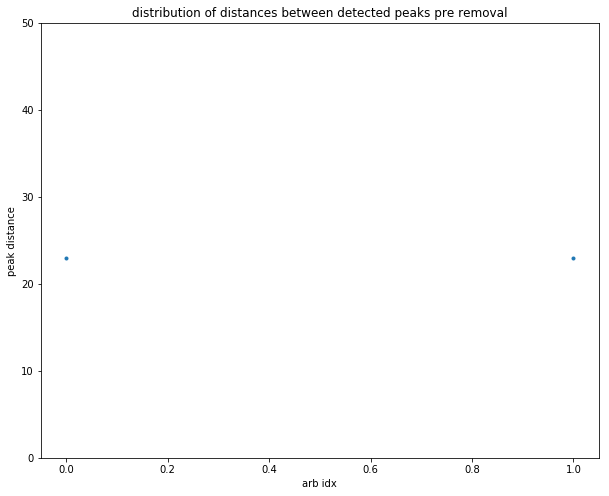

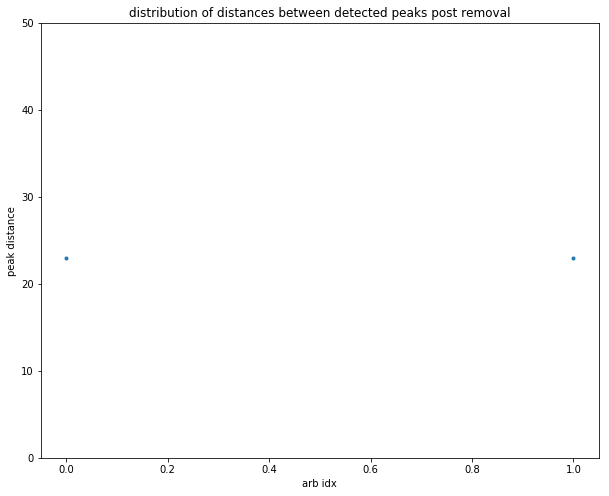

In [9]:
#trim similar peaks (that are within some range of each other and have peaks that are within some range)

minDist = 10 #in abs units of xvec, yvec
#minHeightDiff = 0.1 #in relevant units of Qfn. height probably would be in the range 1.0000xxxxx is permitted

peakDist= []
peakDistPost = []

packetsTrimmed = 0
peaksTrimmed = 0

for relevantInfo_i in relevantInfo:
    peaksTmp = []
    for coors, peak in zip(relevantInfo_i['coors'], relevantInfo_i['peaks']):
        peaksTmp.append((coors, peak))

    filterAgain = True    
    while filterAgain:
        filterAgain = False
        for coor1, peak1 in peaksTmp:
            for coor2, peak2 in peaksTmp:
                if not filterAgain:
                    if not (coor1[0] == coor2[0] and coor1[1] == coor2[1] and peak1 == peak2):

                        dist = np.sqrt((coor1[0] - coor2[0])**2 + (coor1[1] - coor2[1])**2)                        
                        peakDist.append(dist)
                        if dist < minDist:
                            if peak1 >= peak2:                        
                                peaksTmp = [i for i in peaksTmp if not (i[0][0] == coor2[0] and i[0][1] == coor2[1] and i[1] == peak2)]
                                peaksTrimmed += 1
                                filterAgain = True
                                #peaksTmp.remove((coor2, peak2))
                            else:
                                peaksTmp = [i for i in peaksTmp if not (i[0][0] == coor1[0] and i[0][1] == coor1[1] and i[1] == peak1)]
                                peaksTrimmed += 1
                                filterAgain = True
                                #peaksTmp.remove((coor1, peak1))                

            
    for coor1, peak1 in peaksTmp:
        for coor2, peak2 in peaksTmp:
            if coor1[0] != coor2[0] and coor1[1] != coor2[1]:
                dist = np.sqrt((coor1[0] - coor2[0])**2 + (coor1[1] - coor2[1])**2)
                peakDistPost.append(dist)
    
    newCoors = []
    newPeaks = []
    for coor, peak in peaksTmp:
        newCoors.append(coor)
        newPeaks.append(peak)
    if len(newPeaks) != len(relevantInfo_i['peaks']):
        relevantInfo_i['coors'] = newCoors
        relevantInfo_i['peaks'] = newPeaks
        packetsTrimmed += 1
    
                    
print('{} datapoints were trimmed.'.format(packetsTrimmed))    
print('{} peaks were trimmed'.format(peaksTrimmed))

plt.plot(peakDist, '.')
plt.title('distribution of distances between detected peaks pre removal')
plt.ylabel('peak distance')
plt.xlabel('arb idx')
plt.ylim(0, 50)
plt.show();

plt.plot(peakDistPost, '.')
plt.title('distribution of distances between detected peaks post removal')
plt.ylabel('peak distance')
plt.xlabel('arb idx')
plt.ylim(0, 50)
plt.show();

In [55]:
# doublePeaks = []

# for a_i in relevantInfo:
#     if len(a_i['peaks']) == 2:
#         for b in a_i['peaks']:
#             doublePeaks.append(b)
# c = [i['peaks'][0] for i in relevantInfo if len(i['peaks']) == 1]
# concacPeaks = np.sum([c, doublePeaks])

In [56]:
# plt.plot(concacPeaks, '.')
# plt.title('distribution of peak heights in data')
# plt.ylabel('candidate peak heights')
# plt.xlabel('arb index')
# plt.axvline(x=len(c), color='k')
# #plt.ylim(0.01,0.05)

In [57]:
# peaksTest = []
# for relevantInfo_i in relevantInfo:
#     for j in relevantInfo_i['peaks']:
#         peaksTest.append(j)
#     plt.plot(peaksTest, '.')
# print(np.sum([j for j in peaksTest]))

In [58]:
#todo1: play with peaktrimlimit to affect width of leaf
#todo2: if 1 peak r = nothing? that might be the grey region

numIgnored = 0
plotData = []
peakTrimLimit = 0
biPeakLimit = 0.05#0.046
siPeakLimit = 9999999
singlePeakVals = []
for relevantInfo_i in relevantInfo:
    
    trimmedPeaks = []
    foundPeaks = relevantInfo_i['peaks']
    for foundPeak_i in foundPeaks:
        #if foundPeak_i > peakTrimLimit:
        trimmedPeaks.append(foundPeak_i)
    
    if len(trimmedPeaks) == 1:
#         r = 0
#         #singlePeakVals.append(trimmedPeaks[0])
#         if trimmedPeaks[0] > siPeakLimit:
#             plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
        continue
    elif len(trimmedPeaks) == 2:
        #peak0 = relevantInfo_i['peaks'][0]
        #peak1 = relevantInfo_i['peaks'][1]
        peak0 = trimmedPeaks[0]
        peak1 = trimmedPeaks[1]
        if peak0 > biPeakLimit and peak1 > biPeakLimit:
            r = 1 - (abs(peak0-peak1)/(peak0+peak1))
            plotData.append((relevantInfo_i['E'], relevantInfo_i['wd'], r))
#         if r < 0.01:
#             print(peak0)
#             print(peak1)
#             print('bbbb')
#             break
#         if relevantInfo_i['wd'] < 0:
#             print(relevantInfo_i['wd'])
#             #print('aaaa')
#             break
        
    else:
        numIgnored += 1
        #print(relevantInfo_i['E'])
        #print(relevantInfo_i['wd'])
    #ignoreif more than 2 peaks
print(len(plotData))
print(len(trimmedPeaks))
print(numIgnored)
if len(plotData) == 0:
    print('NO BISTABILITY')

491
1
9


In [59]:
plotDataScaled = []
kappa = 0.0012 # 0.0012     
wc = 10.5665 # Cavity frequency/detuning 10.5665
for i in plotData:
    item = []
    item.append(i[0]/kappa)  
    item.append((i[1] - wc)/kappa)    
    item.append(i[2])
    plotDataScaled.append(item)

In [60]:
allDataScaled = []
for relevantInfo_i in relevantInfo:
    item = []
    item.append(relevantInfo_i['E']/kappa)
    item.append((relevantInfo_i['wd'] - wc)/kappa)
    allDataScaled.append(item)

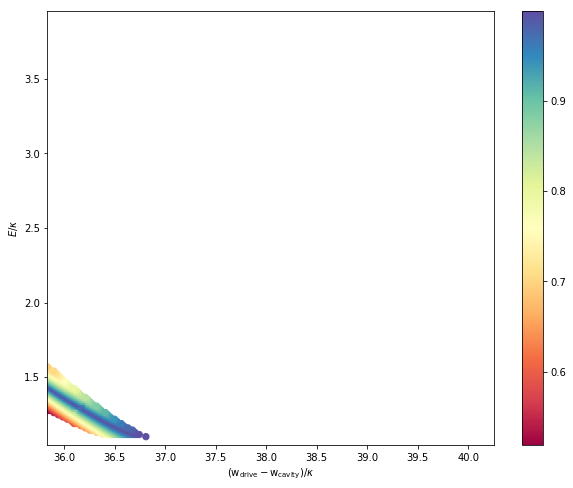

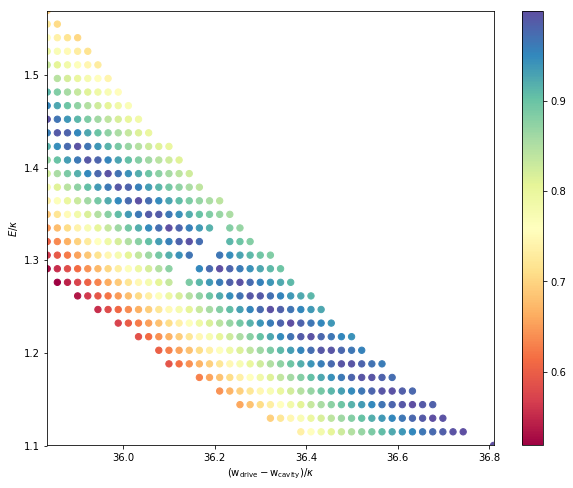

In [61]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

saveDir = 'peaks'
plt.scatter([i[1] for i in plotDataScaled], [i[0] for i in plotDataScaled], c=[i[2] for i in plotDataScaled], s=40, cmap=plt.cm.Spectral)
plt.ylabel(r"$E/\kappa$")
plt.xlabel(r"($\mathregular{w_{drive}}- \mathregular{w_{cavity}}) / \kappa$")
#plt.ylim(min([i[0] for i in plotData]), max([i[0] for i in plotData]))

plt.ylim((min([i[0] for i in allDataScaled])), (max([i[0] for i in allDataScaled])))
plt.xlim((min([i[1] for i in allDataScaled])), (max([i[1] for i in allDataScaled])))
#plt.ylim(0.00125,0.00150)
#plt.xlim(10.6095, 10.6109)
plt.colorbar()
plt.show();

plt.scatter([i[1] for i in plotDataScaled], [i[0] for i in plotDataScaled], c=[i[2] for i in plotDataScaled], s=40, cmap=plt.cm.Spectral)
plt.ylabel(r"$E/\kappa$")
plt.xlabel(r"($\mathregular{w_{drive}}- \mathregular{w_{cavity}}) / \kappa$")
plt.ylim((min([i[0] for i in plotDataScaled])), (max([i[0] for i in plotDataScaled])))
plt.xlim((min([i[1] for i in plotDataScaled])), (max([i[1] for i in plotDataScaled])))
plt.colorbar()
plt.show();


#print("EList = np.linspace(0.0,0.004,40)")
#print("wdList = np.linspace(10.6,10.62,40)")

In [ ]:
# savedInfoTest = pickle.load(open(os.path.join(saveDir,'3.qpeak'), 'rb'))
# print(savedInfoTest.keys())
# print(savedInfoTest)

In [ ]:
# print(routine(savedInfoTest['E_i'],savedInfoTest['wd_i']))

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
